# 目录

[1. 数据加载](#1)  
[2. xgboost训练](#2)  
[3. 新的特征工程 for xgboost](#3)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline
dir_name = 'F:/编程各种文件/part_time/20200205/data/'

In [3]:
# 加载产品实例信息
prd_data = pd.read_csv(dir_name + 'prd_data.csv',encoding='utf-8', low_memory=False)
print('Load product data successfully.\n')
# 加载通话信息、个人信息、DPI信息、终端信息和训练集标签数据
call_data = pd.read_csv(dir_name + 'call_data.csv',encoding='utf-8', low_memory=False)
print('Load call record data successfully.\n')
cust_data = pd.read_csv(dir_name + 'cust_data.csv',encoding='utf-8', low_memory=False)
print('Load customers data successfully.\n')
dpi_data = pd.read_csv(dir_name + 'dpi_data.csv',encoding='utf-8', low_memory=False)
print('Load application analysis data successfully.\n')
trmnl_data = pd.read_csv(dir_name + 'trmnl_data_update.csv',encoding='utf-8', low_memory=False)
print('Load phone terminal data successfully.\n')
train_label = pd.read_csv(dir_name + 'train_result.csv',encoding='utf-8', low_memory=False)
print('Load train label data successfully.\n')

Load product data successfully.

Load call record data successfully.

Load customers data successfully.

Load application analysis data successfully.

Load phone terminal data successfully.

Load train label data successfully.



In [26]:
# 以产品实例信息为主表，关联其余信息表，生成原始数据宽表
all_data = pd.merge(prd_data, call_data, how='left', on='user')
all_data = pd.merge(all_data, cust_data, how='left', on='user')
all_data = pd.merge(all_data, dpi_data, how='left', on='user')
all_data = pd.merge(all_data, trmnl_data, how='left', on='user')
all_data = pd.merge(all_data, train_label, how='left', on='user')
all_data.to_csv(dir_name + 'all_data.csv',index=None)
print("Merged & Saved the file.\n")
#all_data = pd.read_csv('all_data.csv',encoding = 'utf-8')

Merged & Saved the file.



# 数据处理

In [27]:
# 将数据预处理，预处理成不同特征
# 数据增强和特征工程可能从这里开始修改
# TODO
import time
from sklearn.preprocessing import LabelEncoder

def access_net_dt_transform(x):
	if x['cust_access_net_dt'] < 19871100 * 10 ** 6:
		return x['open_date'] * 10 ** 6
	else:
		return x['cust_access_net_dt']

# 计算多少年
def years(str1, str2):
	from datetime import datetime, timedelta
	num_ = 0
	str1_d = datetime.strptime(str1, "%Y")
	str2_d = datetime.strptime(str2, "%Y")
	num_ = str1_d.year - str2_d.year
	return num_

# 计算多少个月
def months(str1, str2):
	from datetime import datetime, timedelta
	if len(str2) == 6:
		str1_d = datetime.strptime(str1, "%Y%m")
		str2_d = datetime.strptime(str2, "%Y%m")
		num = (str1_d.year - str2_d.year) * 12 + (str1_d.month - str2_d.month)
	elif len(str2) == 7:
		if str2[6] == '/':
			str1_d = datetime.strptime(str1, "%Y%m")
			str2_d = datetime.strptime(str2, "%Y/%m/")
			num = (str1_d.year - str2_d.year) * 12 + (str1_d.month - str2_d.month)
		else:
			str1_d = datetime.strptime(str1, "%Y%m")
			str2_d = datetime.strptime(str2, "%Y/%m")
		num = (str1_d.year - str2_d.year) * 12 + (str1_d.month - str2_d.month)
	else:
		num = -1
	return num

def is_year(str2):
	from datetime import datetime, timedelta
	if len(str2) == 6:
		str2_d = datetime.strptime(str2, "%Y%m")
		str2_d = str2_d.year
	else:
		str2_d = '0'
	return str2_d
def is_month(str2):
	from datetime import datetime, timedelta
	if len(str2) == 6:
		str2_d = datetime.strptime(str2, "%Y%m")
		str2_d = str2_d.month
	else:
		str2_d = '0'
	return str2_d
def is_day(str2):
	from datetime import datetime, timedelta
	if len(str2) == 8:
		str2_d = datetime.strptime(str2, "%Y%m%d")
		str2_d = str2_d.day
	else:
		str2_d = '0'
	return str2_d


#读取数据
all_data = pd.read_csv('all_data.csv', encoding='utf-8')
#提取open_date的年月日
all_data['year'] = all_data['open_date'].apply(lambda x: is_year(str(x)[0:6]))
all_data['month'] = all_data['open_date'].apply(lambda x: is_month(str(x)[0:6]))
all_data['day'] = all_data['open_date'].apply(lambda x: is_day(str(x)[0:8]))
all_data['weekofyear'] = all_data['month'] * 30 + all_data['day']  # 计算一年中的第几天
all_data['weekofyear'] = pd.DataFrame(all_data['weekofyear'], dtype=np.float)
all_data['weekofyear'] = all_data['weekofyear'] / 7  # 计算一年中的第几周
print('Date related data modification finished.\n')

# 198711之前的替换为产品开通日期open_date
# print(all_data[ all_data['cust_access_net_dt'] <  19871100 * 10**6][['open_date', 'cust_access_net_dt']].head())
all_data['cust_access_net_dt'] = all_data.apply(access_net_dt_transform, axis=1)
# print(all_data.loc[[334, 379], ['open_date', 'cust_access_net_dt']])

# 简化起见，把开通日期在20190930以后的异常值替换为20190930,以接近真实的开通时间
# all_data.loc[all_data['open_date'] > 20190930, 'open_date'] = all_data['birth_date'].median()
all_data.loc[all_data['open_date'] > 20190930, 'open_date'] = 20190930
print('Date exception modification finished.\n')
# 简化起见，把开通日期在20010930以后的异常值替换为-1
# all_data.loc[all_data['birth_date']>20010930,'birth_date']=all_data['birth_date'].median()
# all_data.loc[all_data['birth_date']<19290930,'birth_date']=all_data['birth_date'].median()

# 对客户入网时间、出生日期、终端自注册短信发送时间、用户的开通日期做此类处理。
all_data['cust_access_net_dt'] = all_data['cust_access_net_dt'].apply(lambda x: months('201910', str(x)[0:6]))
all_data['birth_date'] = all_data['birth_date'].apply(lambda x: months('201910', str(x)[0:6]))  # 生日只求年龄
all_data['register_date'] = all_data['register_date'].apply(lambda x: months('201910', str(x)[0:7]))
all_data['open_date'] = all_data['open_date'].apply(lambda x: months('201910', str(x)[0:6]))

# all_data.loc[all_data['birth_date']>234,'birth_date']=all_data['birth_date'].median()
all_data.loc[all_data['birth_date'] < 234, 'birth_date'] = all_data['birth_date'].median()
print('Date exception modification finished.\n')

# 缺失值,如果为时间，则填充中位数时间
column = ['cust_access_net_dt', 'credit_level', 'membership_level', 'gender', 'cust_point', 'inet_pd_inst_cnt',
		  'star_level', 'birth_date', 'open_date', 'register_date']
for col in column:
	all_data[col].fillna(all_data[col].median(), inplace=True)
	
#app浏览量用均值填充
col_fill0 = ['app1_visits', 'app2_visits', 'app3_visits', 'app4_visits', 'app5_visits', 'app6_visits',
			 'app7_visits', 'app8_visits', 'market_price', ]
for col in col_fill0:
	all_data[col].fillna(all_data[col].mean(), inplace=True)

#产品用-1填充	
col_mean = ['pro_brand', 'term_model']
for col in col_mean:
	all_data[col].fillna(-1, inplace=True)

all_data.fillna(-1, inplace=True)

#价格做对数变换，靠近正态分布
all_data['market_price'] = np.log(all_data['market_price'].values + 1)
# print(all_data['market_price'].head())
all_data['inet_pd_inst_cnt'] = np.log(all_data['inet_pd_inst_cnt'].values + 1)
# print(all_data['inet_pd_inst_cnt'].head())
all_data['cust_point'] = np.log(all_data['cust_point'].values + 1)
# print(all_data['cust_point'].head())
print('customer & product info modification finished.\n')

# 标签编码
le_label = LabelEncoder().fit(all_data['label'][all_data['label'] != -1])
all_data.loc[all_data['label'] != -1, 'label'] = le_label.transform(all_data['label'][all_data['label'] != -1])

# 级别编码
le_credit_level = LabelEncoder().fit(all_data['credit_level'])
all_data['credit_level'] = le_credit_level.transform(all_data['credit_level'])
le_membership_level = LabelEncoder().fit(all_data['membership_level'])
all_data['membership_level'] = le_membership_level.transform(all_data['membership_level'])
le_star_level = LabelEncoder().fit(all_data['star_level'])
all_data['star_level'] = le_star_level.transform(all_data['star_level'])

# 特征增加
all_data['avg_tocall'] = all_data['dt_m_1009'] / all_data['dt_m_1006']  # 平均主叫通话时长
all_data['avg_becall'] = all_data['dt_m_1015'] / all_data['dt_m_1012']  # 平均被叫通话时长

all_data['10s_times'] = all_data['dt_m_1032'] * all_data['dt_m_1006']  # 本月10s内主叫通话次数
all_data['30s_times'] = all_data['dt_m_1034'] * all_data['dt_m_1006']  # 本月30s内主叫通话次数
all_data['1m_times'] = all_data['dt_m_1035'] * all_data['dt_m_1006']  # 本月1min内主叫通话次数

all_data['10s_times_all_rate'] = all_data['dt_m_1032'] * all_data['dt_m_1006'] / all_data[
	'dt_m_1000']  # 本月10s内主叫通话次数占总数
all_data['30s_times_all_rate'] = all_data['dt_m_1034'] * all_data['dt_m_1006'] / all_data[
	'dt_m_1000']  # 本月30s内主叫通话次数占总数
all_data['1m_times_all_rate'] = all_data['dt_m_1035'] * all_data['dt_m_1006'] / all_data[
	'dt_m_1000']  # 本月1min内主叫通话次数占总数

all_data['call_avg_person'] = all_data['dt_m_1000'] / all_data['dt_m_1041']  # 本月每人的平均通话次数
all_data['tocall_avg_person'] = all_data['dt_m_1006'] / all_data['dt_m_1051']  # 本月每人平均主叫次数
all_data['becall_avg_person'] = all_data['dt_m_1012'] / (all_data['dt_m_1041'] - all_data['dt_m_1051'])  # 本月每人平均被叫次数

all_data['call_avg_region'] = all_data['dt_m_1006'] / all_data['dt_m_1067']  # 本月各区域平均通话次数
#长途总每个时长、长途时长占总时长、长途次数占总次数、主叫被叫占总长途
all_data['long_distance_duration_avg'] = all_data['dt_m_1099'] / all_data['dt_m_1096']
all_data['long_distance_duration_all'] = all_data['dt_m_1099'] / all_data['dt_m_1003']
all_data['long_distance_duration_avg'] = all_data['dt_m_1096'] / all_data['dt_m_1000']

all_data['long_distance_tocall_times_rate'] = all_data['dt_m_1102'] / all_data['dt_m_1096']
all_data['long_distance_tocall_times_rate'] = all_data['dt_m_1108'] / all_data['dt_m_1096']
all_data['long_distance_tocall_duration_rate'] = all_data['dt_m_1105'] / all_data['dt_m_1099']
all_data['long_distance_becall_duration_rate'] = all_data['dt_m_1111'] / all_data['dt_m_1099']
#主叫被叫通话时长占总时长
all_data['tocall_duration_rate'] = all_data['dt_m_1009'] / all_data['dt_m_1003']
all_data['becall_duration_rate'] = all_data['dt_m_1015'] / all_data['dt_m_1003']
#长途主叫占比、时长、平均时间
all_data['long_distance_tocall_rate'] = all_data['dt_m_1102'] / all_data['dt_m_1000']
all_data['long_distance_tocall_avg'] = all_data['dt_m_1105'] / all_data['dt_m_1000']
all_data['long_distance_tocall_duration'] = all_data['dt_m_1105'] / all_data['dt_m_1003']
all_data['long_distance_tocall_rate2'] = all_data['dt_m_1102'] / all_data['dt_m_1006']
#长途被叫占比、时长、平均时间
all_data['long_distance_becall_rate'] = all_data['dt_m_1108'] / all_data['dt_m_1000']
all_data['long_distance_becall_avg'] = all_data['dt_m_1111'] / all_data['dt_m_1108']
all_data['long_distance_becall_duration'] = all_data['dt_m_1111'] / all_data['dt_m_1003']
all_data['long_distance_becall_rate2'] = all_data['dt_m_1108'] / all_data['dt_m_1012']
#各时间段通话占比
all_data['7_18_rate'] = all_data['dt_m_1073'] / all_data['dt_m_1000']
all_data['18_22_rate'] = all_data['dt_m_1074'] / all_data['dt_m_1000']
all_data['22_24_rate'] = all_data['dt_m_1075'] / all_data['dt_m_1000']
#本月主叫占全部人数/3月占比
all_data['people_tocall_rate'] = all_data['dt_m_1051'] / all_data['dt_m_1041']
all_data['people_tocall_rate_3month'] = all_data['dt_m_1052'] / all_data['dt_m_1043']

all_data['duration_avg_call'] = all_data['dt_m_1003'] / all_data['dt_m_1000']
all_data['month_to_call_rate'] = all_data['dt_m_1006'] / all_data['dt_m_1000']
all_data['month_to_toll_rate'] = all_data['dt_m_1012'] / all_data['dt_m_1000']
all_data['sum_app'] = all_data['app1_visits'] + all_data['app2_visits'] + all_data['app3_visits'] + all_data[
	'app4_visits'] + all_data['app5_visits'] + all_data['app6_visits'] + all_data['app7_visits'] + all_data[
						  'app8_visits']
#主叫和上网次数之比
all_data['month_call_internet_rate'] = all_data['dt_m_1000'] / all_data['dt_m_1617']
all_data['month_tocall_internet_rate'] = all_data['dt_m_1006'] / all_data['dt_m_1617']
#每个时间段主叫占全部比例
all_data['7_18_tocall_all_rate'] = all_data['dt_m_1085'] * all_data['dt_m_1006'] / all_data['dt_m_1073']
all_data['18_22_tocall_all_rate'] = all_data['dt_m_1086'] * all_data['dt_m_1006'] / all_data['dt_m_1074']
all_data['22_24_tocall_all_rate'] = all_data['dt_m_1087'] * all_data['dt_m_1006'] / all_data['dt_m_1075']
all_data['7_18__month_all_rate'] = all_data['dt_m_1085'] * all_data['dt_m_1006'] / all_data['dt_m_1000']
all_data['18_22__month_all_rate'] = all_data['dt_m_1086'] * all_data['dt_m_1006'] / all_data['dt_m_1000']
all_data['22_24_month_all_rate'] = all_data['dt_m_1087'] * all_data['dt_m_1006'] / all_data['dt_m_1000']
#10/30/60秒内主叫个数
all_data['10_seconds_tocall'] = all_data['dt_m_1032'] * all_data['dt_m_1000']
all_data['30_seconds_tocall'] = all_data['dt_m_1034'] * all_data['dt_m_1000']
all_data['60_seconds_tocall'] = all_data['dt_m_1035'] * all_data['dt_m_1000']

all_data['10_seconds_tocall_rate'] = all_data['dt_m_1032'] * all_data['dt_m_1000'] / all_data['dt_m_1006']
all_data['30_seconds_tocall_rate'] = all_data['dt_m_1034'] * all_data['dt_m_1000'] / all_data['dt_m_1006']
all_data['60_seconds_tocall_rate'] = all_data['dt_m_1035'] * all_data['dt_m_1000'] / all_data['dt_m_1006']
#每个人通话时间\每个人主动通话时间
all_data['people_call_duration'] = all_data['dt_m_1003'] / all_data['dt_m_1041']
all_data['people_tocall_duration'] = all_data['dt_m_1009'] / all_data['dt_m_1051']
#本月1平均1个人打几个电话/主叫几个
all_data['people_call_avg'] = all_data['dt_m_1000'] / all_data['dt_m_1041']
all_data['people_tocall_avg'] = all_data['dt_m_1006'] / all_data['dt_m_1051']

#每次app打开消耗流量/每次上网时长、流量、
all_data['app_avg_flow'] = all_data['dt_m_1620'] / all_data['sum_app']
all_data['app_avg_flow_each_internet'] = all_data['dt_m_1620'] / all_data['dt_m_1617'] * 30
all_data['app_avg_time_each_internet'] = all_data['dt_m_1618'] / all_data['dt_m_1617'] * 30

#app1和app8的占比
all_data['rate_app1'] = all_data['app1_visits'] / all_data['sum_app']
all_data['rate_app2'] = all_data['app2_visits'] / all_data['sum_app']
all_data['rate_app3'] = all_data['app3_visits'] / all_data['sum_app']
all_data['rate_app4'] = all_data['app4_visits'] / all_data['sum_app']
all_data['rate_app5'] = all_data['app5_visits'] / all_data['sum_app']
all_data['rate_app6'] = all_data['app6_visits'] / all_data['sum_app']
all_data['rate_app7'] = all_data['app7_visits'] / all_data['sum_app']
all_data['rate_app8'] = all_data['app8_visits'] / all_data['sum_app']

# 删除中间计算量年月日列
all_data.drop(['year', 'month', 'day'], axis=1, inplace=True)

all_data.fillna(0, inplace=True)
all_data = all_data.replace([np.inf, -np.inf], 0)
all_data = all_data.replace(np.nan, 0)
print('feature addition finished.\n')
all_data.to_csv(dir_name + 'all_data_.csv', index=None, encoding='utf-8')
print("Merged & Saved the file.\n")


Date related data modification finished.

Date exception modification finished.

Date exception modification finished.



C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:116: RuntimeWarning: invalid value encountered in log


customer & product info modification finished.

feature addition finished.

Merged & Saved the file.



In [28]:
#价格做对数变换，靠近正态分布
# all_data = pd.read_csv(dir_name + 'all_data_.csv', encoding = 'utf-8', low_memory=False)
all_data['market_price'] = np.log(all_data['market_price'].values+1)
print(all_data['market_price'].head())
all_data['inet_pd_inst_cnt'] = np.log(all_data['inet_pd_inst_cnt'].values+1)
print(all_data['inet_pd_inst_cnt'].head())
all_data['cust_point'] = np.log(all_data['cust_point'].values+1)
print(all_data['cust_point'].head())


0    2.205072
1    1.863574
2    2.139542
3    1.837880
4    2.139542
Name: market_price, dtype: float64
0    0.741276
1    0.959135
2    0.526589
3    0.869742
4    1.162283
Name: inet_pd_inst_cnt, dtype: float64
0    2.268271
1    1.968973
2    0.000000
3    2.168433
4    2.217458
Name: cust_point, dtype: float64


In [ ]:
# 这里展示类别分布情况
all_data = pd.read_csv(dir_name + 'all_data_.csv', encoding = 'utf-8', low_memory=False)
train_data = all_data[all_data['label']!=-1]
test_data = all_data[all_data['label']==-1]

# print('训练数据类别分布情况')
# print(train_data['label'].value_counts() / train_data['label'].value_counts().sum())

In [4]:
# 这里将32w用户数据进行分割，分割为训练集和验证集
from sklearn.model_selection import train_test_split

# X=train_data.drop(['label','user','product_nbr'],axis=1)
X=train_data.drop(['label','user','product_nbr', 'pro_brand', 'term_model'
#                    , 'last_year_capture_user_flag', 'membership_level'
                  ],axis=1)
y=train_data['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=22)

<div id='2'><div>

## 2. xgboost训练

In [5]:
# 计算正确率
from sklearn.metrics import f1_score, precision_score, recall_score
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

def print_metrics(y_true, y_pred):
    f1 = f1_score(y_true, y_pred, average='macro')
    p = precision_score(y_true, y_pred, average='macro')
    r = recall_score(y_true, y_pred, average='macro')
    print('f1',f1)
    print('p',p)
    print('r',r)

    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y_true, y_pred)
    print('confusion matrix', cm)
    cm = cm / cm.sum(axis=0, keepdims=True)
    print('confusion matrix', cm)

In [6]:
y_train_1 = y_train.apply(lambda x:1.0 if x!=2.0 else x)
print(y_train.value_counts())
print(y_train_1.value_counts())

2    197987
3     12523
0      7534
1      6252
4      1633
Name: label, dtype: int64
2.0    197987
1.0     27942
Name: label, dtype: int64


In [7]:
#基于Scikit-learn接口的xgboost多分类
import datetime

## 第一级的二分类
# 转换标签
y_train_1 = y_train.apply(lambda x:1 if x!=2.0 else 0) # 1-其他类别(0,1,3,4)，0-数目最大的类别(2)
X_train_1 = X_train
model = xgb.XGBClassifier(learning_rate=0.07, n_estimators=500, max_depth=9, min_child_weight=1,
                subsample=0.9, colsample_bytree=0.9, gamma=0.2, reg_alpha=0.05, reg_lambda=0.1, n_jobs=-1,
                          objective='binary:logistic')
starttime = datetime.datetime.now()
xgb_model_1 = model.fit(X_train_1, y_train_1)
endtime = datetime.datetime.now()
print("耗时：%d" %(endtime - starttime).seconds +"s")

# 对训练集进行预测
y_pred_1 = xgb_model_1.predict(X_train_1)
print_metrics(y_train_1, y_pred_1)

# 对测试集进行预测
y_pred_1_test = xgb_model_1.predict(X_test)
# 转换标签
y_true_1 = y_test.apply(lambda x:1 if x!=2.0 else 0)
print_metrics(y_true_1, y_pred_1_test)

耗时：509s
f1 0.9999897900292
p 0.9999974745944198
r 0.9999821057905662
confusion matrix [[197987      0]
 [     1  27941]]
confusion matrix [[9.99994949e-01 0.00000000e+00]
 [5.05081116e-06 1.00000000e+00]]
f1 0.9667090377140899
p 0.9743314777953058
r 0.9594158998879672
confusion matrix [[84451   468]
 [  901 11008]]
confusion matrix [[0.98944372 0.04078076]
 [0.01055628 0.95921924]]


In [38]:
cv_params = {'max_depth': [5, 6, 7, 8, 9, 10]}
other_params = {'learning_rate': 0.07, 'n_estimators': 500, 'max_depth': 9, 'min_child_weight': 1, 'seed': 0,
                'subsample': 0.9, 'colsample_bytree': 0.9, 'gamma': 0.2, 'reg_alpha': 0.05, 'reg_lambda': 0.1}
model = xgb.XGBClassifier(**other_params)
optimized_GBM = GridSearchCV(estimator=model, param_grid=cv_params, scoring='f1', cv=3, verbose=1, n_jobs=-1)
optimized_GBM.fit(X_train_1, y_train_1)
evalute_result = optimized_GBM.cv_results_
print('每轮迭代运行结果:{0}'.format(evalute_result))
print('参数的最佳取值：{0}'.format(optimized_GBM.best_params_))
print('最佳模型得分:{0}'.format(optimized_GBM.best_score_))

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


In [7]:
# 准备第二级分类的数据
from imblearn.over_sampling import SMOTE

# idx = np.where(y_pred_1 == 1)[0]
# X_train_2 = X_train.iloc[idx, :]
# y_train_2 = y_train.iloc[idx]

sm = SMOTE(random_state=22)
X_train_2, y_train_2 = sm.fit_resample(X_train, y_train)



Using TensorFlow backend.


In [8]:
# 第二级分类器数据特征处理
# TODO
import time
from sklearn.preprocessing import LabelEncoder
# 这里将32w用户数据进行分割，分割为训练集和验证集
from sklearn.model_selection import train_test_split

# X=train_data.drop(['label','user','product_nbr'],axis=1)
X=train_data.drop(['label','user','product_nbr', 'pro_brand', 'term_model'
#                    , 'last_year_capture_user_flag', 'membership_level'
                  ],axis=1)
y=train_data['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=22)

# 计算多少年
def years(str1, str2):
	from datetime import datetime, timedelta
	num_ = 0
	str1_d = datetime.strptime(str1, "%Y")
	str2_d = datetime.strptime(str2, "%Y")
	num_ = str1_d.year - str2_d.year
	return num_

def feature_modify(all_data):

	# 对custom_data的特征处理入网时间、出生日期、终端自注册短信发送时间、用户的开通日期做此类处理。
	# all_data['age'] = all_data['birth_date'].apply(lambda x: years('2020', str(x)[0:4]))  # 生日只求年龄
	all_data.drop(['birth_date', 'membership_level', 'gender',
					'star_level', 'cust_point'], axis=1, inplace=True)
	
	print('customer data feature modification finished.\n')
	
	
	# 对terminal_data的特征处理品牌。
	all_data.drop(['last_year_capture_user_flag'], axis=1, inplace=True)
	
	
	# 特征增加
	all_data['merchase_prd_rate'] = all_data['inet_pd_inst_cnt'] / all_data['cust_access_net_dt']  # 买产品频率
	
	# 比率更重要比次数更能表征特征
	all_data.drop(['10s_times', '30s_times', '1m_times'], axis=1, inplace=True)
	
	# 主叫被叫分开才对分类有意义
	all_data.drop(['call_avg_person'], axis=1, inplace=True)
	
	# 每月对于每个区域平均通话次数是否有影响？先放着
	# all_data.drop(['call_avg_region'], axis=1, inplace=True)
	
	# 长途电话时长占总时长冗余
	all_data.drop(['long_distance_duration_all'], axis=1, inplace=True)
	# 长途电话次数占总次数冗余
	all_data.drop(['long_distance_duration_avg'], axis=1, inplace=True)
	
	# 主叫长途电话时长占比冗余
	all_data.drop(['long_distance_tocall_duration_rate'], axis=1, inplace=True)
	# 被叫长途电话时长占比冗余
	all_data.drop(['long_distance_becall_duration_rate'], axis=1, inplace=True)
	
	#长途主叫占比、时长、平均时间
	all_data.drop(['long_distance_tocall_rate', 'long_distance_tocall_avg', 'long_distance_tocall_duration'
					  , 'long_distance_tocall_rate'], axis=1, inplace=True)
	all_data.drop(['long_distance_becall_rate', 'long_distance_becall_avg', 'long_distance_becall_duration'
					  , 'long_distance_becall_rate'], axis=1, inplace=True)
	
	# 主叫被叫都分开了，总频率重要性较低
	all_data.drop(['duration_avg_call', 'month_to_call_rate'], axis=1, inplace=True)
	
	
	#10/30/60秒内主叫个数
	all_data.drop(['10_seconds_tocall', '30_seconds_tocall', '60_seconds_tocall'], axis=1, inplace=True)
	all_data.drop(['10_seconds_tocall_rate', '30_seconds_tocall_rate', '60_seconds_tocall_rate'], axis=1, inplace=True)
	
	
	#每个人通话时间\每个人主动通话时间:每个人平均时长特征不重要
	all_data.drop(['people_call_duration', 'people_tocall_duration'], axis=1, inplace=True)
	
	#本月1平均1个人打几个电话没有主叫重要
	all_data.drop(['people_call_avg'], axis=1, inplace=True)
	
	
	# 将call类型转换为二次特征以后，把所有一次特征delete
	all_data.drop(['dt_m_1000', 'dt_m_1003', 'dt_m_1004', 'dt_m_1005', 'dt_m_1006', 'dt_m_1009', 'dt_m_1011', 'dt_m_1012', 'dt_m_1015',
				   'dt_m_1017', 'dt_m_1027', 'dt_m_1028', 'dt_m_1032', 'dt_m_1034', 'dt_m_1035', 'dt_m_1041', 'dt_m_1043', 'dt_m_1051',
				   'dt_m_1052', 'dt_m_1067', 'dt_m_1068', 'dt_m_1073', 'dt_m_1074', 'dt_m_1075', 'dt_m_1085', 'dt_m_1086', 'dt_m_1087',
				   'dt_m_1096', 'dt_m_1099', 'dt_m_1102', 'dt_m_1105', 'dt_m_1108', 'dt_m_1111', 'dt_m_1594', 'dt_m_1601', 'dt_m_1617',
				   'dt_m_1618', 'dt_m_1620', 'dt_m_1630', 'dt_m_1633'], axis=1, inplace=True)
	
	all_data.fillna(0, inplace=True)
	all_data = all_data.replace([np.inf, -np.inf], 0)
	all_data = all_data.replace(np.nan, 0)
	print('feature addition finished.\n')
	
	
X_test_2 = pd.DataFrame(X_test)
feature_modify(X_test_2)
# feature_modify(all_data_)
X_test_2.to_csv(dir_name + 'all_data_1.csv',index=None)


customer data feature modification finished.

feature addition finished.



In [52]:
# 定义一个MLP作为第二级多分类试试
import os
import numpy as np
import matplotlib.pyplot as plt
import torch as th
from torchvision.datasets import mnist
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils import data
import torch.nn.functional as F
import torch.optim as optim
from torch import nn

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# define the parameters
learning_rate = 0.01
num_epoches = 1
momentum = 0.5

# definition of network
class Net(nn.Module):
	"""
	使用sequential构建网络，该函数的功能是将网络的层组合到一起
	"""
	def __init__(self, in_dim, n_hidden_1, n_hidden_2, out_dim):
		super(Net, self).__init__()
		self.layer1 = nn.Sequential(nn.Linear(in_dim, n_hidden_1), nn.BatchNorm1d(n_hidden_1))
		self.layer2 = nn.Sequential(nn.Linear(n_hidden_1, n_hidden_2), nn.BatchNorm1d(n_hidden_2))
		self.layer3 = nn.Sequential(nn.Linear(n_hidden_2, out_dim))

	def forward(self, x):
		x = F.relu(self.layer1(x))
		x = F.relu(self.layer2(x))
		x = self.layer3(x)
		return x


In [53]:
# 自定义torch数据集
class SDataset(data.Dataset):
	def __init__(self, data_, label_):
		self.Data = data_
		#print(self.Data)
		self.label = label_
		
	def __getitem__(self, item):
		tdata = th.from_numpy(self.Data[item])
		label = th.tensor(self.label[item])
		return tdata, label

	def __len__(self):
		return len(self.Data)
	

In [71]:
## 第二级的多分类
# TODO: complete the network
idx = np.where(y_pred_1 == 1)[0]
X_train_2 = X_train.iloc[idx, :]
y_train_2 = y_train.iloc[idx]
for i in range(len(y_train_2)):
	y_train_2.iloc[i] -= 1
	if y_train_2.iloc[i] == -1:
		y_train_2.iloc[i] = 1
feature_modify(X_train_2)
# 准备训练和测试数据，适应网络的
X_train_2_tmp = np.array(X_train_2)
# print(X_train_2_tmp)
y_train_2_tmp = np.array(y_train_2)
X_key = X_train_2.keys()
x_train = SDataset(X_train_2_tmp, y_train_2_tmp)
x_loader = data.DataLoader(x_train,batch_size=500)
x_train_loader = data.DataLoader(x_train, batch_size=len(x_train))
feature_num = X_train_2.shape[1]

# 实例化网络
# define the processing device
device = th.device("cpu")

model = Net(feature_num, 300, 100, 4)

# 将网络导入到cpu内存
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

#X_train_2 = pd.DataFrame(X_train_2,index=[i for i in range(len(X_train_2))])
#y_train_2 = pd.DataFrame(y_train_2,index=[i for i in range(len(y_train_2))])
starttime = datetime.datetime.now()
for epoch in range(num_epoches):
	# print('train_round {}'.format(epoch))
	model.train()
	if epoch % 5 == 0:
		optimizer.param_groups[0]['lr']*=0.1

	for dad, label in x_loader:
		dad = dad.to(device)
		label = label.to(device)
	
		# forward
		dad = th.tensor(dad, dtype=th.float32)
		print(dad)
		out = model(dad)
		loss = criterion(out, label)
	
		# backpropagation
		optimizer.zero_grad()
		loss.backward()
		optimizer.step()
	
		# calculate the accuracy in classification
		_, pred = out.max(1)

endtime = datetime.datetime.now()
print("耗时：%d" %(endtime - starttime).seconds +"s")
# test
print('test here!!!\n')

model.eval()
y_pred_2 = []
for dad, label in x_train_loader:
	dad = dad.to(device)
	label = label.to(device)

	# forward
	dad = th.tensor(dad, dtype=th.float32)
	out = model(dad)
	loss = criterion(out, label)

	# calculate the accuracy in classification
	_, pred = out.max(1)
	print(pred)

y_pred_2 = pred
# model = xgb.XGBClassifier(learning_rate=0.07, n_estimators=500, max_depth=6, min_child_weight=1, objective='multi:softprob',
#                 subsample=0.9, colsample_bytree=0.9, gamma=0.5, reg_alpha=0.05, reg_lambda=0.1, n_jobs=-1,
#                          num_class=4)

# xgb_model_2 = model.fit(X_train_2, y_train_2)


# 对训练集进行预测
print_metrics(y_train_2, y_pred_2)

# 对测试集进行预测
# 拿到一级分类器分类为其他类别(0,1,3,4)的样本
idx = np.where(y_pred_1_test == 1)[0]
X_2 = X_test.iloc[idx, :]
feature_modify(X_2)
y_pred_2 = []
for i in range(len(X_2)):
	X_2[i] = X_2[i].to(device)
	y_test[i] = y_test[i].to(device)

	# forward
	out = model(X_2[i])
	loss = criterion(out, y_test[i])

	# calculate the accuracy in classification
	_, pred = out.max(1)
	y_pred_2.append(pred)
y_true_2 = y_test.iloc[idx]

print('二级分类器：')
print_metrics(y_true_2, y_pred_2)

customer data feature modification finished.



C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


feature addition finished.



C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


tensor([[4.3000e+01, 4.3000e+01, 6.0000e+00,  ..., 6.5722e-04, 6.2436e-03,
         3.2239e-02],
        [5.9000e+01, 5.9000e+01, 0.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         1.1748e-02],
        [1.9000e+01, 1.9000e+01, 1.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         5.7822e-02],
        ...,
        [5.0000e+00, 5.0000e+00, 1.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         1.3863e-01],
        [4.0000e+00, 4.0000e+00, 1.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         4.4794e-01],
        [5.1000e+01, 5.1000e+01, 6.0000e+00,  ..., 1.9692e-02, 1.1583e-03,
         4.5149e-02]])
tensor([[4.0000e+00, 3.2000e+01, 0.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         5.0295e-02],
        [5.0000e+00, 5.0000e+00, 1.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         1.3863e-01],
        [3.0000e+00, 1.5700e+02, 6.0000e+00,  ..., 0.0000e+00, 2.1429e-01,
         1.0251e-02],
        ...,
        [5.0000e+00, 5.0000e+00, 1.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         2.7726e-01],
   

          1.1834e-02,  1.1552e-01]])
tensor([[1.5200e+02, 1.5200e+02, 6.0000e+00,  ..., 0.0000e+00, 4.1416e-02,
         9.1204e-03],
        [2.0000e+00, 7.2000e+01, 6.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         1.5259e-02],
        [4.0000e+00, 4.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 1.0000e+00,
         4.0236e-01],
        ...,
        [1.1000e+01, 3.1000e+01, 0.0000e+00,  ..., 6.3034e-02, 1.7236e-01,
         2.2360e-02],
        [1.1000e+01, 1.1000e+01, 1.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         6.3013e-02],
        [5.0000e+00, 5.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         4.7958e-01]])
tensor([[5.0000e+00, 5.0000e+00, 5.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         5.8889e-01],
        [2.9000e+01, 2.9000e+01, 6.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         2.3902e-02],
        [1.3000e+01, 6.6000e+01, 1.0000e+00,  ..., 0.0000e+00, 1.1561e-02,
         1.0502e-02],
        ...,
        [4.0000e+00, 4.0000e+00, 6.0000e+00,  ..., 6.3786e-02, 

         2.6824e-01]])
tensor([[1.9000e+01, 1.9000e+01, 6.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         3.6481e-02],
        [2.0000e+00, 2.0000e+00, 2.0000e+00,  ..., 1.3544e-02, 0.0000e+00,
         3.4657e-01],
        [8.0000e+00, 1.0000e+01, 0.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         1.0986e-01],
        ...,
        [2.0000e+00, 2.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         8.0472e-01],
        [2.5000e+01, 2.6000e+01, 0.0000e+00,  ..., 1.9068e-01, 2.3480e-01,
         8.4509e-02],
        [4.0000e+00, 4.0000e+00, 6.0000e+00,  ..., 1.6974e-02, 1.1972e-02,
         1.7329e-01]])
tensor([[2.0000e+00, 2.0000e+00, 6.0000e+00,  ..., 4.1895e-02, 6.2249e-02,
         3.4657e-01],
        [5.0000e+00, 5.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         2.7726e-01],
        [3.0000e+00, 3.0000e+00, 0.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         2.3105e-01],
        ...,
        [1.3000e+01, 1.3000e+01, 0.0000e+00,  ..., 0.0000e+00, 6.8145e-02,
  

          7.9359e-02, -1.6094e+00]])
tensor([[2.0000e+00, 3.9000e+01, 0.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         4.5943e-02],
        [5.5000e+01, 5.5000e+01, 6.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         1.9975e-02],
        [4.9000e+01, 1.0200e+02, 0.0000e+00,  ..., 0.0000e+00, 1.4723e-01,
         1.7566e-02],
        ...,
        [2.0000e+00, 4.0000e+00, 2.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         3.4657e-01],
        [1.1700e+02, 1.1700e+02, 6.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         2.1923e-02],
        [3.2000e+01, 1.4200e+02, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         1.7499e-02]])
tensor([[1.9000e+01, 1.9000e+01, 1.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         3.6481e-02],
        [5.0000e+00, 5.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         1.3863e-01],
        [5.0000e+00, 1.6000e+01, 1.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         1.0059e-01],
        ...,
        [3.7000e+01, 1.1000e+02, 3.0000e+00,  ..., 0.0000e+00, 

         1.1552e-01]])
tensor([[4.3000e+01, 4.3000e+01, 6.0000e+00,  ..., 6.5722e-04, 6.2436e-03,
         3.2239e-02],
        [5.9000e+01, 5.9000e+01, 0.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         1.1748e-02],
        [1.9000e+01, 1.9000e+01, 1.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         5.7822e-02],
        ...,
        [5.0000e+00, 5.0000e+00, 1.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         1.3863e-01],
        [4.0000e+00, 4.0000e+00, 1.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         4.4794e-01],
        [5.1000e+01, 5.1000e+01, 6.0000e+00,  ..., 1.9692e-02, 1.1583e-03,
         4.5149e-02]])
tensor([[4.0000e+00, 3.2000e+01, 0.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         5.0295e-02],
        [5.0000e+00, 5.0000e+00, 1.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         1.3863e-01],
        [3.0000e+00, 1.5700e+02, 6.0000e+00,  ..., 0.0000e+00, 2.1429e-01,
         1.0251e-02],
        ...,
        [5.0000e+00, 5.0000e+00, 1.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
  

          1.1834e-02,  1.1552e-01]])
tensor([[1.5200e+02, 1.5200e+02, 6.0000e+00,  ..., 0.0000e+00, 4.1416e-02,
         9.1204e-03],
        [2.0000e+00, 7.2000e+01, 6.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         1.5259e-02],
        [4.0000e+00, 4.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 1.0000e+00,
         4.0236e-01],
        ...,
        [1.1000e+01, 3.1000e+01, 0.0000e+00,  ..., 6.3034e-02, 1.7236e-01,
         2.2360e-02],
        [1.1000e+01, 1.1000e+01, 1.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         6.3013e-02],
        [5.0000e+00, 5.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         4.7958e-01]])
tensor([[5.0000e+00, 5.0000e+00, 5.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         5.8889e-01],
        [2.9000e+01, 2.9000e+01, 6.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         2.3902e-02],
        [1.3000e+01, 6.6000e+01, 1.0000e+00,  ..., 0.0000e+00, 1.1561e-02,
         1.0502e-02],
        ...,
        [4.0000e+00, 4.0000e+00, 6.0000e+00,  ..., 6.3786e-02, 

         2.6824e-01]])
tensor([[1.9000e+01, 1.9000e+01, 6.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         3.6481e-02],
        [2.0000e+00, 2.0000e+00, 2.0000e+00,  ..., 1.3544e-02, 0.0000e+00,
         3.4657e-01],
        [8.0000e+00, 1.0000e+01, 0.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         1.0986e-01],
        ...,
        [2.0000e+00, 2.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         8.0472e-01],
        [2.5000e+01, 2.6000e+01, 0.0000e+00,  ..., 1.9068e-01, 2.3480e-01,
         8.4509e-02],
        [4.0000e+00, 4.0000e+00, 6.0000e+00,  ..., 1.6974e-02, 1.1972e-02,
         1.7329e-01]])
tensor([[2.0000e+00, 2.0000e+00, 6.0000e+00,  ..., 4.1895e-02, 6.2249e-02,
         3.4657e-01],
        [5.0000e+00, 5.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         2.7726e-01],
        [3.0000e+00, 3.0000e+00, 0.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         2.3105e-01],
        ...,
        [1.3000e+01, 1.3000e+01, 0.0000e+00,  ..., 0.0000e+00, 6.8145e-02,
  

          7.9359e-02, -1.6094e+00]])
tensor([[2.0000e+00, 3.9000e+01, 0.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         4.5943e-02],
        [5.5000e+01, 5.5000e+01, 6.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         1.9975e-02],
        [4.9000e+01, 1.0200e+02, 0.0000e+00,  ..., 0.0000e+00, 1.4723e-01,
         1.7566e-02],
        ...,
        [2.0000e+00, 4.0000e+00, 2.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         3.4657e-01],
        [1.1700e+02, 1.1700e+02, 6.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         2.1923e-02],
        [3.2000e+01, 1.4200e+02, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         1.7499e-02]])
tensor([[1.9000e+01, 1.9000e+01, 1.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         3.6481e-02],
        [5.0000e+00, 5.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         1.3863e-01],
        [5.0000e+00, 1.6000e+01, 1.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         1.0059e-01],
        ...,
        [3.7000e+01, 1.1000e+02, 3.0000e+00,  ..., 0.0000e+00, 

         1.1552e-01]])
tensor([[4.3000e+01, 4.3000e+01, 6.0000e+00,  ..., 6.5722e-04, 6.2436e-03,
         3.2239e-02],
        [5.9000e+01, 5.9000e+01, 0.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         1.1748e-02],
        [1.9000e+01, 1.9000e+01, 1.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         5.7822e-02],
        ...,
        [5.0000e+00, 5.0000e+00, 1.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         1.3863e-01],
        [4.0000e+00, 4.0000e+00, 1.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         4.4794e-01],
        [5.1000e+01, 5.1000e+01, 6.0000e+00,  ..., 1.9692e-02, 1.1583e-03,
         4.5149e-02]])
tensor([[4.0000e+00, 3.2000e+01, 0.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         5.0295e-02],
        [5.0000e+00, 5.0000e+00, 1.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         1.3863e-01],
        [3.0000e+00, 1.5700e+02, 6.0000e+00,  ..., 0.0000e+00, 2.1429e-01,
         1.0251e-02],
        ...,
        [5.0000e+00, 5.0000e+00, 1.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
  

          1.1834e-02,  1.1552e-01]])
tensor([[1.5200e+02, 1.5200e+02, 6.0000e+00,  ..., 0.0000e+00, 4.1416e-02,
         9.1204e-03],
        [2.0000e+00, 7.2000e+01, 6.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         1.5259e-02],
        [4.0000e+00, 4.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 1.0000e+00,
         4.0236e-01],
        ...,
        [1.1000e+01, 3.1000e+01, 0.0000e+00,  ..., 6.3034e-02, 1.7236e-01,
         2.2360e-02],
        [1.1000e+01, 1.1000e+01, 1.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         6.3013e-02],
        [5.0000e+00, 5.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         4.7958e-01]])
tensor([[5.0000e+00, 5.0000e+00, 5.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         5.8889e-01],
        [2.9000e+01, 2.9000e+01, 6.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         2.3902e-02],
        [1.3000e+01, 6.6000e+01, 1.0000e+00,  ..., 0.0000e+00, 1.1561e-02,
         1.0502e-02],
        ...,
        [4.0000e+00, 4.0000e+00, 6.0000e+00,  ..., 6.3786e-02, 

         2.6824e-01]])
tensor([[1.9000e+01, 1.9000e+01, 6.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         3.6481e-02],
        [2.0000e+00, 2.0000e+00, 2.0000e+00,  ..., 1.3544e-02, 0.0000e+00,
         3.4657e-01],
        [8.0000e+00, 1.0000e+01, 0.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         1.0986e-01],
        ...,
        [2.0000e+00, 2.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         8.0472e-01],
        [2.5000e+01, 2.6000e+01, 0.0000e+00,  ..., 1.9068e-01, 2.3480e-01,
         8.4509e-02],
        [4.0000e+00, 4.0000e+00, 6.0000e+00,  ..., 1.6974e-02, 1.1972e-02,
         1.7329e-01]])
tensor([[2.0000e+00, 2.0000e+00, 6.0000e+00,  ..., 4.1895e-02, 6.2249e-02,
         3.4657e-01],
        [5.0000e+00, 5.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         2.7726e-01],
        [3.0000e+00, 3.0000e+00, 0.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         2.3105e-01],
        ...,
        [1.3000e+01, 1.3000e+01, 0.0000e+00,  ..., 0.0000e+00, 6.8145e-02,
  

          7.9359e-02, -1.6094e+00]])
tensor([[2.0000e+00, 3.9000e+01, 0.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         4.5943e-02],
        [5.5000e+01, 5.5000e+01, 6.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         1.9975e-02],
        [4.9000e+01, 1.0200e+02, 0.0000e+00,  ..., 0.0000e+00, 1.4723e-01,
         1.7566e-02],
        ...,
        [2.0000e+00, 4.0000e+00, 2.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         3.4657e-01],
        [1.1700e+02, 1.1700e+02, 6.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         2.1923e-02],
        [3.2000e+01, 1.4200e+02, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         1.7499e-02]])
tensor([[1.9000e+01, 1.9000e+01, 1.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         3.6481e-02],
        [5.0000e+00, 5.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         1.3863e-01],
        [5.0000e+00, 1.6000e+01, 1.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         1.0059e-01],
        ...,
        [3.7000e+01, 1.1000e+02, 3.0000e+00,  ..., 0.0000e+00, 

         1.1552e-01]])
tensor([[4.3000e+01, 4.3000e+01, 6.0000e+00,  ..., 6.5722e-04, 6.2436e-03,
         3.2239e-02],
        [5.9000e+01, 5.9000e+01, 0.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         1.1748e-02],
        [1.9000e+01, 1.9000e+01, 1.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         5.7822e-02],
        ...,
        [5.0000e+00, 5.0000e+00, 1.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         1.3863e-01],
        [4.0000e+00, 4.0000e+00, 1.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         4.4794e-01],
        [5.1000e+01, 5.1000e+01, 6.0000e+00,  ..., 1.9692e-02, 1.1583e-03,
         4.5149e-02]])
tensor([[4.0000e+00, 3.2000e+01, 0.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         5.0295e-02],
        [5.0000e+00, 5.0000e+00, 1.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         1.3863e-01],
        [3.0000e+00, 1.5700e+02, 6.0000e+00,  ..., 0.0000e+00, 2.1429e-01,
         1.0251e-02],
        ...,
        [5.0000e+00, 5.0000e+00, 1.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
  

          1.1834e-02,  1.1552e-01]])
tensor([[1.5200e+02, 1.5200e+02, 6.0000e+00,  ..., 0.0000e+00, 4.1416e-02,
         9.1204e-03],
        [2.0000e+00, 7.2000e+01, 6.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         1.5259e-02],
        [4.0000e+00, 4.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 1.0000e+00,
         4.0236e-01],
        ...,
        [1.1000e+01, 3.1000e+01, 0.0000e+00,  ..., 6.3034e-02, 1.7236e-01,
         2.2360e-02],
        [1.1000e+01, 1.1000e+01, 1.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         6.3013e-02],
        [5.0000e+00, 5.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         4.7958e-01]])
tensor([[5.0000e+00, 5.0000e+00, 5.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         5.8889e-01],
        [2.9000e+01, 2.9000e+01, 6.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         2.3902e-02],
        [1.3000e+01, 6.6000e+01, 1.0000e+00,  ..., 0.0000e+00, 1.1561e-02,
         1.0502e-02],
        ...,
        [4.0000e+00, 4.0000e+00, 6.0000e+00,  ..., 6.3786e-02, 

         2.6824e-01]])
tensor([[1.9000e+01, 1.9000e+01, 6.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         3.6481e-02],
        [2.0000e+00, 2.0000e+00, 2.0000e+00,  ..., 1.3544e-02, 0.0000e+00,
         3.4657e-01],
        [8.0000e+00, 1.0000e+01, 0.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         1.0986e-01],
        ...,
        [2.0000e+00, 2.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         8.0472e-01],
        [2.5000e+01, 2.6000e+01, 0.0000e+00,  ..., 1.9068e-01, 2.3480e-01,
         8.4509e-02],
        [4.0000e+00, 4.0000e+00, 6.0000e+00,  ..., 1.6974e-02, 1.1972e-02,
         1.7329e-01]])
tensor([[2.0000e+00, 2.0000e+00, 6.0000e+00,  ..., 4.1895e-02, 6.2249e-02,
         3.4657e-01],
        [5.0000e+00, 5.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         2.7726e-01],
        [3.0000e+00, 3.0000e+00, 0.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         2.3105e-01],
        ...,
        [1.3000e+01, 1.3000e+01, 0.0000e+00,  ..., 0.0000e+00, 6.8145e-02,
  

          7.9359e-02, -1.6094e+00]])
tensor([[2.0000e+00, 3.9000e+01, 0.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         4.5943e-02],
        [5.5000e+01, 5.5000e+01, 6.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         1.9975e-02],
        [4.9000e+01, 1.0200e+02, 0.0000e+00,  ..., 0.0000e+00, 1.4723e-01,
         1.7566e-02],
        ...,
        [2.0000e+00, 4.0000e+00, 2.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         3.4657e-01],
        [1.1700e+02, 1.1700e+02, 6.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         2.1923e-02],
        [3.2000e+01, 1.4200e+02, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         1.7499e-02]])
tensor([[1.9000e+01, 1.9000e+01, 1.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         3.6481e-02],
        [5.0000e+00, 5.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         1.3863e-01],
        [5.0000e+00, 1.6000e+01, 1.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         1.0059e-01],
        ...,
        [3.7000e+01, 1.1000e+02, 3.0000e+00,  ..., 0.0000e+00, 

         1.1552e-01]])
tensor([[4.3000e+01, 4.3000e+01, 6.0000e+00,  ..., 6.5722e-04, 6.2436e-03,
         3.2239e-02],
        [5.9000e+01, 5.9000e+01, 0.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         1.1748e-02],
        [1.9000e+01, 1.9000e+01, 1.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         5.7822e-02],
        ...,
        [5.0000e+00, 5.0000e+00, 1.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         1.3863e-01],
        [4.0000e+00, 4.0000e+00, 1.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         4.4794e-01],
        [5.1000e+01, 5.1000e+01, 6.0000e+00,  ..., 1.9692e-02, 1.1583e-03,
         4.5149e-02]])
tensor([[4.0000e+00, 3.2000e+01, 0.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         5.0295e-02],
        [5.0000e+00, 5.0000e+00, 1.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         1.3863e-01],
        [3.0000e+00, 1.5700e+02, 6.0000e+00,  ..., 0.0000e+00, 2.1429e-01,
         1.0251e-02],
        ...,
        [5.0000e+00, 5.0000e+00, 1.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
  

          1.1834e-02,  1.1552e-01]])
tensor([[1.5200e+02, 1.5200e+02, 6.0000e+00,  ..., 0.0000e+00, 4.1416e-02,
         9.1204e-03],
        [2.0000e+00, 7.2000e+01, 6.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         1.5259e-02],
        [4.0000e+00, 4.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 1.0000e+00,
         4.0236e-01],
        ...,
        [1.1000e+01, 3.1000e+01, 0.0000e+00,  ..., 6.3034e-02, 1.7236e-01,
         2.2360e-02],
        [1.1000e+01, 1.1000e+01, 1.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         6.3013e-02],
        [5.0000e+00, 5.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         4.7958e-01]])
tensor([[5.0000e+00, 5.0000e+00, 5.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         5.8889e-01],
        [2.9000e+01, 2.9000e+01, 6.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         2.3902e-02],
        [1.3000e+01, 6.6000e+01, 1.0000e+00,  ..., 0.0000e+00, 1.1561e-02,
         1.0502e-02],
        ...,
        [4.0000e+00, 4.0000e+00, 6.0000e+00,  ..., 6.3786e-02, 

         2.6824e-01]])
tensor([[1.9000e+01, 1.9000e+01, 6.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         3.6481e-02],
        [2.0000e+00, 2.0000e+00, 2.0000e+00,  ..., 1.3544e-02, 0.0000e+00,
         3.4657e-01],
        [8.0000e+00, 1.0000e+01, 0.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         1.0986e-01],
        ...,
        [2.0000e+00, 2.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         8.0472e-01],
        [2.5000e+01, 2.6000e+01, 0.0000e+00,  ..., 1.9068e-01, 2.3480e-01,
         8.4509e-02],
        [4.0000e+00, 4.0000e+00, 6.0000e+00,  ..., 1.6974e-02, 1.1972e-02,
         1.7329e-01]])
tensor([[2.0000e+00, 2.0000e+00, 6.0000e+00,  ..., 4.1895e-02, 6.2249e-02,
         3.4657e-01],
        [5.0000e+00, 5.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         2.7726e-01],
        [3.0000e+00, 3.0000e+00, 0.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         2.3105e-01],
        ...,
        [1.3000e+01, 1.3000e+01, 0.0000e+00,  ..., 0.0000e+00, 6.8145e-02,
  

          7.9359e-02, -1.6094e+00]])
tensor([[2.0000e+00, 3.9000e+01, 0.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         4.5943e-02],
        [5.5000e+01, 5.5000e+01, 6.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         1.9975e-02],
        [4.9000e+01, 1.0200e+02, 0.0000e+00,  ..., 0.0000e+00, 1.4723e-01,
         1.7566e-02],
        ...,
        [2.0000e+00, 4.0000e+00, 2.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         3.4657e-01],
        [1.1700e+02, 1.1700e+02, 6.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         2.1923e-02],
        [3.2000e+01, 1.4200e+02, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         1.7499e-02]])
tensor([[1.9000e+01, 1.9000e+01, 1.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         3.6481e-02],
        [5.0000e+00, 5.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         1.3863e-01],
        [5.0000e+00, 1.6000e+01, 1.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         1.0059e-01],
        ...,
        [3.7000e+01, 1.1000e+02, 3.0000e+00,  ..., 0.0000e+00, 

         1.1552e-01]])
tensor([[4.3000e+01, 4.3000e+01, 6.0000e+00,  ..., 6.5722e-04, 6.2436e-03,
         3.2239e-02],
        [5.9000e+01, 5.9000e+01, 0.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         1.1748e-02],
        [1.9000e+01, 1.9000e+01, 1.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         5.7822e-02],
        ...,
        [5.0000e+00, 5.0000e+00, 1.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         1.3863e-01],
        [4.0000e+00, 4.0000e+00, 1.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         4.4794e-01],
        [5.1000e+01, 5.1000e+01, 6.0000e+00,  ..., 1.9692e-02, 1.1583e-03,
         4.5149e-02]])
tensor([[4.0000e+00, 3.2000e+01, 0.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         5.0295e-02],
        [5.0000e+00, 5.0000e+00, 1.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         1.3863e-01],
        [3.0000e+00, 1.5700e+02, 6.0000e+00,  ..., 0.0000e+00, 2.1429e-01,
         1.0251e-02],
        ...,
        [5.0000e+00, 5.0000e+00, 1.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
  

          1.1834e-02,  1.1552e-01]])
tensor([[1.5200e+02, 1.5200e+02, 6.0000e+00,  ..., 0.0000e+00, 4.1416e-02,
         9.1204e-03],
        [2.0000e+00, 7.2000e+01, 6.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         1.5259e-02],
        [4.0000e+00, 4.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 1.0000e+00,
         4.0236e-01],
        ...,
        [1.1000e+01, 3.1000e+01, 0.0000e+00,  ..., 6.3034e-02, 1.7236e-01,
         2.2360e-02],
        [1.1000e+01, 1.1000e+01, 1.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         6.3013e-02],
        [5.0000e+00, 5.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         4.7958e-01]])
tensor([[5.0000e+00, 5.0000e+00, 5.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         5.8889e-01],
        [2.9000e+01, 2.9000e+01, 6.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         2.3902e-02],
        [1.3000e+01, 6.6000e+01, 1.0000e+00,  ..., 0.0000e+00, 1.1561e-02,
         1.0502e-02],
        ...,
        [4.0000e+00, 4.0000e+00, 6.0000e+00,  ..., 6.3786e-02, 

         2.6824e-01]])
tensor([[1.9000e+01, 1.9000e+01, 6.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         3.6481e-02],
        [2.0000e+00, 2.0000e+00, 2.0000e+00,  ..., 1.3544e-02, 0.0000e+00,
         3.4657e-01],
        [8.0000e+00, 1.0000e+01, 0.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         1.0986e-01],
        ...,
        [2.0000e+00, 2.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         8.0472e-01],
        [2.5000e+01, 2.6000e+01, 0.0000e+00,  ..., 1.9068e-01, 2.3480e-01,
         8.4509e-02],
        [4.0000e+00, 4.0000e+00, 6.0000e+00,  ..., 1.6974e-02, 1.1972e-02,
         1.7329e-01]])
tensor([[2.0000e+00, 2.0000e+00, 6.0000e+00,  ..., 4.1895e-02, 6.2249e-02,
         3.4657e-01],
        [5.0000e+00, 5.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         2.7726e-01],
        [3.0000e+00, 3.0000e+00, 0.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         2.3105e-01],
        ...,
        [1.3000e+01, 1.3000e+01, 0.0000e+00,  ..., 0.0000e+00, 6.8145e-02,
  

          7.9359e-02, -1.6094e+00]])
tensor([[2.0000e+00, 3.9000e+01, 0.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         4.5943e-02],
        [5.5000e+01, 5.5000e+01, 6.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         1.9975e-02],
        [4.9000e+01, 1.0200e+02, 0.0000e+00,  ..., 0.0000e+00, 1.4723e-01,
         1.7566e-02],
        ...,
        [2.0000e+00, 4.0000e+00, 2.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         3.4657e-01],
        [1.1700e+02, 1.1700e+02, 6.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         2.1923e-02],
        [3.2000e+01, 1.4200e+02, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         1.7499e-02]])
tensor([[1.9000e+01, 1.9000e+01, 1.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         3.6481e-02],
        [5.0000e+00, 5.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         1.3863e-01],
        [5.0000e+00, 1.6000e+01, 1.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         1.0059e-01],
        ...,
        [3.7000e+01, 1.1000e+02, 3.0000e+00,  ..., 0.0000e+00, 

         1.1552e-01]])
tensor([[4.3000e+01, 4.3000e+01, 6.0000e+00,  ..., 6.5722e-04, 6.2436e-03,
         3.2239e-02],
        [5.9000e+01, 5.9000e+01, 0.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         1.1748e-02],
        [1.9000e+01, 1.9000e+01, 1.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         5.7822e-02],
        ...,
        [5.0000e+00, 5.0000e+00, 1.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         1.3863e-01],
        [4.0000e+00, 4.0000e+00, 1.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         4.4794e-01],
        [5.1000e+01, 5.1000e+01, 6.0000e+00,  ..., 1.9692e-02, 1.1583e-03,
         4.5149e-02]])
tensor([[4.0000e+00, 3.2000e+01, 0.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         5.0295e-02],
        [5.0000e+00, 5.0000e+00, 1.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         1.3863e-01],
        [3.0000e+00, 1.5700e+02, 6.0000e+00,  ..., 0.0000e+00, 2.1429e-01,
         1.0251e-02],
        ...,
        [5.0000e+00, 5.0000e+00, 1.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
  

          1.1834e-02,  1.1552e-01]])
tensor([[1.5200e+02, 1.5200e+02, 6.0000e+00,  ..., 0.0000e+00, 4.1416e-02,
         9.1204e-03],
        [2.0000e+00, 7.2000e+01, 6.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         1.5259e-02],
        [4.0000e+00, 4.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 1.0000e+00,
         4.0236e-01],
        ...,
        [1.1000e+01, 3.1000e+01, 0.0000e+00,  ..., 6.3034e-02, 1.7236e-01,
         2.2360e-02],
        [1.1000e+01, 1.1000e+01, 1.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         6.3013e-02],
        [5.0000e+00, 5.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         4.7958e-01]])
tensor([[5.0000e+00, 5.0000e+00, 5.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         5.8889e-01],
        [2.9000e+01, 2.9000e+01, 6.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         2.3902e-02],
        [1.3000e+01, 6.6000e+01, 1.0000e+00,  ..., 0.0000e+00, 1.1561e-02,
         1.0502e-02],
        ...,
        [4.0000e+00, 4.0000e+00, 6.0000e+00,  ..., 6.3786e-02, 

         2.6824e-01]])
tensor([[1.9000e+01, 1.9000e+01, 6.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         3.6481e-02],
        [2.0000e+00, 2.0000e+00, 2.0000e+00,  ..., 1.3544e-02, 0.0000e+00,
         3.4657e-01],
        [8.0000e+00, 1.0000e+01, 0.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         1.0986e-01],
        ...,
        [2.0000e+00, 2.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         8.0472e-01],
        [2.5000e+01, 2.6000e+01, 0.0000e+00,  ..., 1.9068e-01, 2.3480e-01,
         8.4509e-02],
        [4.0000e+00, 4.0000e+00, 6.0000e+00,  ..., 1.6974e-02, 1.1972e-02,
         1.7329e-01]])
tensor([[2.0000e+00, 2.0000e+00, 6.0000e+00,  ..., 4.1895e-02, 6.2249e-02,
         3.4657e-01],
        [5.0000e+00, 5.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         2.7726e-01],
        [3.0000e+00, 3.0000e+00, 0.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         2.3105e-01],
        ...,
        [1.3000e+01, 1.3000e+01, 0.0000e+00,  ..., 0.0000e+00, 6.8145e-02,
  

          7.9359e-02, -1.6094e+00]])
tensor([[2.0000e+00, 3.9000e+01, 0.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         4.5943e-02],
        [5.5000e+01, 5.5000e+01, 6.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         1.9975e-02],
        [4.9000e+01, 1.0200e+02, 0.0000e+00,  ..., 0.0000e+00, 1.4723e-01,
         1.7566e-02],
        ...,
        [2.0000e+00, 4.0000e+00, 2.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         3.4657e-01],
        [1.1700e+02, 1.1700e+02, 6.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         2.1923e-02],
        [3.2000e+01, 1.4200e+02, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         1.7499e-02]])
tensor([[1.9000e+01, 1.9000e+01, 1.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         3.6481e-02],
        [5.0000e+00, 5.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         1.3863e-01],
        [5.0000e+00, 1.6000e+01, 1.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         1.0059e-01],
        ...,
        [3.7000e+01, 1.1000e+02, 3.0000e+00,  ..., 0.0000e+00, 

         1.1552e-01]])
tensor([[4.3000e+01, 4.3000e+01, 6.0000e+00,  ..., 6.5722e-04, 6.2436e-03,
         3.2239e-02],
        [5.9000e+01, 5.9000e+01, 0.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         1.1748e-02],
        [1.9000e+01, 1.9000e+01, 1.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         5.7822e-02],
        ...,
        [5.0000e+00, 5.0000e+00, 1.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         1.3863e-01],
        [4.0000e+00, 4.0000e+00, 1.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         4.4794e-01],
        [5.1000e+01, 5.1000e+01, 6.0000e+00,  ..., 1.9692e-02, 1.1583e-03,
         4.5149e-02]])
tensor([[4.0000e+00, 3.2000e+01, 0.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         5.0295e-02],
        [5.0000e+00, 5.0000e+00, 1.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         1.3863e-01],
        [3.0000e+00, 1.5700e+02, 6.0000e+00,  ..., 0.0000e+00, 2.1429e-01,
         1.0251e-02],
        ...,
        [5.0000e+00, 5.0000e+00, 1.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
  

          1.1834e-02,  1.1552e-01]])
tensor([[1.5200e+02, 1.5200e+02, 6.0000e+00,  ..., 0.0000e+00, 4.1416e-02,
         9.1204e-03],
        [2.0000e+00, 7.2000e+01, 6.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         1.5259e-02],
        [4.0000e+00, 4.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 1.0000e+00,
         4.0236e-01],
        ...,
        [1.1000e+01, 3.1000e+01, 0.0000e+00,  ..., 6.3034e-02, 1.7236e-01,
         2.2360e-02],
        [1.1000e+01, 1.1000e+01, 1.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         6.3013e-02],
        [5.0000e+00, 5.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         4.7958e-01]])
tensor([[5.0000e+00, 5.0000e+00, 5.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         5.8889e-01],
        [2.9000e+01, 2.9000e+01, 6.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         2.3902e-02],
        [1.3000e+01, 6.6000e+01, 1.0000e+00,  ..., 0.0000e+00, 1.1561e-02,
         1.0502e-02],
        ...,
        [4.0000e+00, 4.0000e+00, 6.0000e+00,  ..., 6.3786e-02, 

         2.6824e-01]])
tensor([[1.9000e+01, 1.9000e+01, 6.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         3.6481e-02],
        [2.0000e+00, 2.0000e+00, 2.0000e+00,  ..., 1.3544e-02, 0.0000e+00,
         3.4657e-01],
        [8.0000e+00, 1.0000e+01, 0.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         1.0986e-01],
        ...,
        [2.0000e+00, 2.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         8.0472e-01],
        [2.5000e+01, 2.6000e+01, 0.0000e+00,  ..., 1.9068e-01, 2.3480e-01,
         8.4509e-02],
        [4.0000e+00, 4.0000e+00, 6.0000e+00,  ..., 1.6974e-02, 1.1972e-02,
         1.7329e-01]])
tensor([[2.0000e+00, 2.0000e+00, 6.0000e+00,  ..., 4.1895e-02, 6.2249e-02,
         3.4657e-01],
        [5.0000e+00, 5.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         2.7726e-01],
        [3.0000e+00, 3.0000e+00, 0.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         2.3105e-01],
        ...,
        [1.3000e+01, 1.3000e+01, 0.0000e+00,  ..., 0.0000e+00, 6.8145e-02,
  

          7.9359e-02, -1.6094e+00]])
tensor([[2.0000e+00, 3.9000e+01, 0.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         4.5943e-02],
        [5.5000e+01, 5.5000e+01, 6.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         1.9975e-02],
        [4.9000e+01, 1.0200e+02, 0.0000e+00,  ..., 0.0000e+00, 1.4723e-01,
         1.7566e-02],
        ...,
        [2.0000e+00, 4.0000e+00, 2.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         3.4657e-01],
        [1.1700e+02, 1.1700e+02, 6.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         2.1923e-02],
        [3.2000e+01, 1.4200e+02, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         1.7499e-02]])
tensor([[1.9000e+01, 1.9000e+01, 1.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         3.6481e-02],
        [5.0000e+00, 5.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         1.3863e-01],
        [5.0000e+00, 1.6000e+01, 1.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         1.0059e-01],
        ...,
        [3.7000e+01, 1.1000e+02, 3.0000e+00,  ..., 0.0000e+00, 

         1.1552e-01]])
tensor([[4.3000e+01, 4.3000e+01, 6.0000e+00,  ..., 6.5722e-04, 6.2436e-03,
         3.2239e-02],
        [5.9000e+01, 5.9000e+01, 0.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         1.1748e-02],
        [1.9000e+01, 1.9000e+01, 1.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         5.7822e-02],
        ...,
        [5.0000e+00, 5.0000e+00, 1.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         1.3863e-01],
        [4.0000e+00, 4.0000e+00, 1.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         4.4794e-01],
        [5.1000e+01, 5.1000e+01, 6.0000e+00,  ..., 1.9692e-02, 1.1583e-03,
         4.5149e-02]])
tensor([[4.0000e+00, 3.2000e+01, 0.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         5.0295e-02],
        [5.0000e+00, 5.0000e+00, 1.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         1.3863e-01],
        [3.0000e+00, 1.5700e+02, 6.0000e+00,  ..., 0.0000e+00, 2.1429e-01,
         1.0251e-02],
        ...,
        [5.0000e+00, 5.0000e+00, 1.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
  

          1.1834e-02,  1.1552e-01]])
tensor([[1.5200e+02, 1.5200e+02, 6.0000e+00,  ..., 0.0000e+00, 4.1416e-02,
         9.1204e-03],
        [2.0000e+00, 7.2000e+01, 6.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         1.5259e-02],
        [4.0000e+00, 4.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 1.0000e+00,
         4.0236e-01],
        ...,
        [1.1000e+01, 3.1000e+01, 0.0000e+00,  ..., 6.3034e-02, 1.7236e-01,
         2.2360e-02],
        [1.1000e+01, 1.1000e+01, 1.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         6.3013e-02],
        [5.0000e+00, 5.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         4.7958e-01]])
tensor([[5.0000e+00, 5.0000e+00, 5.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         5.8889e-01],
        [2.9000e+01, 2.9000e+01, 6.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         2.3902e-02],
        [1.3000e+01, 6.6000e+01, 1.0000e+00,  ..., 0.0000e+00, 1.1561e-02,
         1.0502e-02],
        ...,
        [4.0000e+00, 4.0000e+00, 6.0000e+00,  ..., 6.3786e-02, 

         2.6824e-01]])
tensor([[1.9000e+01, 1.9000e+01, 6.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         3.6481e-02],
        [2.0000e+00, 2.0000e+00, 2.0000e+00,  ..., 1.3544e-02, 0.0000e+00,
         3.4657e-01],
        [8.0000e+00, 1.0000e+01, 0.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         1.0986e-01],
        ...,
        [2.0000e+00, 2.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         8.0472e-01],
        [2.5000e+01, 2.6000e+01, 0.0000e+00,  ..., 1.9068e-01, 2.3480e-01,
         8.4509e-02],
        [4.0000e+00, 4.0000e+00, 6.0000e+00,  ..., 1.6974e-02, 1.1972e-02,
         1.7329e-01]])
tensor([[2.0000e+00, 2.0000e+00, 6.0000e+00,  ..., 4.1895e-02, 6.2249e-02,
         3.4657e-01],
        [5.0000e+00, 5.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         2.7726e-01],
        [3.0000e+00, 3.0000e+00, 0.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         2.3105e-01],
        ...,
        [1.3000e+01, 1.3000e+01, 0.0000e+00,  ..., 0.0000e+00, 6.8145e-02,
  

          7.9359e-02, -1.6094e+00]])
tensor([[2.0000e+00, 3.9000e+01, 0.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         4.5943e-02],
        [5.5000e+01, 5.5000e+01, 6.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         1.9975e-02],
        [4.9000e+01, 1.0200e+02, 0.0000e+00,  ..., 0.0000e+00, 1.4723e-01,
         1.7566e-02],
        ...,
        [2.0000e+00, 4.0000e+00, 2.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         3.4657e-01],
        [1.1700e+02, 1.1700e+02, 6.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         2.1923e-02],
        [3.2000e+01, 1.4200e+02, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         1.7499e-02]])
tensor([[1.9000e+01, 1.9000e+01, 1.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         3.6481e-02],
        [5.0000e+00, 5.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         1.3863e-01],
        [5.0000e+00, 1.6000e+01, 1.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         1.0059e-01],
        ...,
        [3.7000e+01, 1.1000e+02, 3.0000e+00,  ..., 0.0000e+00, 

         1.1552e-01]])
tensor([[4.3000e+01, 4.3000e+01, 6.0000e+00,  ..., 6.5722e-04, 6.2436e-03,
         3.2239e-02],
        [5.9000e+01, 5.9000e+01, 0.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         1.1748e-02],
        [1.9000e+01, 1.9000e+01, 1.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         5.7822e-02],
        ...,
        [5.0000e+00, 5.0000e+00, 1.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         1.3863e-01],
        [4.0000e+00, 4.0000e+00, 1.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         4.4794e-01],
        [5.1000e+01, 5.1000e+01, 6.0000e+00,  ..., 1.9692e-02, 1.1583e-03,
         4.5149e-02]])
tensor([[4.0000e+00, 3.2000e+01, 0.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         5.0295e-02],
        [5.0000e+00, 5.0000e+00, 1.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         1.3863e-01],
        [3.0000e+00, 1.5700e+02, 6.0000e+00,  ..., 0.0000e+00, 2.1429e-01,
         1.0251e-02],
        ...,
        [5.0000e+00, 5.0000e+00, 1.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
  

          1.1834e-02,  1.1552e-01]])
tensor([[1.5200e+02, 1.5200e+02, 6.0000e+00,  ..., 0.0000e+00, 4.1416e-02,
         9.1204e-03],
        [2.0000e+00, 7.2000e+01, 6.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         1.5259e-02],
        [4.0000e+00, 4.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 1.0000e+00,
         4.0236e-01],
        ...,
        [1.1000e+01, 3.1000e+01, 0.0000e+00,  ..., 6.3034e-02, 1.7236e-01,
         2.2360e-02],
        [1.1000e+01, 1.1000e+01, 1.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         6.3013e-02],
        [5.0000e+00, 5.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         4.7958e-01]])
tensor([[5.0000e+00, 5.0000e+00, 5.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         5.8889e-01],
        [2.9000e+01, 2.9000e+01, 6.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         2.3902e-02],
        [1.3000e+01, 6.6000e+01, 1.0000e+00,  ..., 0.0000e+00, 1.1561e-02,
         1.0502e-02],
        ...,
        [4.0000e+00, 4.0000e+00, 6.0000e+00,  ..., 6.3786e-02, 

         2.6824e-01]])
tensor([[1.9000e+01, 1.9000e+01, 6.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         3.6481e-02],
        [2.0000e+00, 2.0000e+00, 2.0000e+00,  ..., 1.3544e-02, 0.0000e+00,
         3.4657e-01],
        [8.0000e+00, 1.0000e+01, 0.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         1.0986e-01],
        ...,
        [2.0000e+00, 2.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         8.0472e-01],
        [2.5000e+01, 2.6000e+01, 0.0000e+00,  ..., 1.9068e-01, 2.3480e-01,
         8.4509e-02],
        [4.0000e+00, 4.0000e+00, 6.0000e+00,  ..., 1.6974e-02, 1.1972e-02,
         1.7329e-01]])
tensor([[2.0000e+00, 2.0000e+00, 6.0000e+00,  ..., 4.1895e-02, 6.2249e-02,
         3.4657e-01],
        [5.0000e+00, 5.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         2.7726e-01],
        [3.0000e+00, 3.0000e+00, 0.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         2.3105e-01],
        ...,
        [1.3000e+01, 1.3000e+01, 0.0000e+00,  ..., 0.0000e+00, 6.8145e-02,
  

          7.9359e-02, -1.6094e+00]])
tensor([[2.0000e+00, 3.9000e+01, 0.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         4.5943e-02],
        [5.5000e+01, 5.5000e+01, 6.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         1.9975e-02],
        [4.9000e+01, 1.0200e+02, 0.0000e+00,  ..., 0.0000e+00, 1.4723e-01,
         1.7566e-02],
        ...,
        [2.0000e+00, 4.0000e+00, 2.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         3.4657e-01],
        [1.1700e+02, 1.1700e+02, 6.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         2.1923e-02],
        [3.2000e+01, 1.4200e+02, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         1.7499e-02]])
tensor([[1.9000e+01, 1.9000e+01, 1.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         3.6481e-02],
        [5.0000e+00, 5.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         1.3863e-01],
        [5.0000e+00, 1.6000e+01, 1.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         1.0059e-01],
        ...,
        [3.7000e+01, 1.1000e+02, 3.0000e+00,  ..., 0.0000e+00, 

         1.1552e-01]])
tensor([[4.3000e+01, 4.3000e+01, 6.0000e+00,  ..., 6.5722e-04, 6.2436e-03,
         3.2239e-02],
        [5.9000e+01, 5.9000e+01, 0.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         1.1748e-02],
        [1.9000e+01, 1.9000e+01, 1.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         5.7822e-02],
        ...,
        [5.0000e+00, 5.0000e+00, 1.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         1.3863e-01],
        [4.0000e+00, 4.0000e+00, 1.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         4.4794e-01],
        [5.1000e+01, 5.1000e+01, 6.0000e+00,  ..., 1.9692e-02, 1.1583e-03,
         4.5149e-02]])
tensor([[4.0000e+00, 3.2000e+01, 0.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         5.0295e-02],
        [5.0000e+00, 5.0000e+00, 1.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         1.3863e-01],
        [3.0000e+00, 1.5700e+02, 6.0000e+00,  ..., 0.0000e+00, 2.1429e-01,
         1.0251e-02],
        ...,
        [5.0000e+00, 5.0000e+00, 1.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
  

          1.1834e-02,  1.1552e-01]])
tensor([[1.5200e+02, 1.5200e+02, 6.0000e+00,  ..., 0.0000e+00, 4.1416e-02,
         9.1204e-03],
        [2.0000e+00, 7.2000e+01, 6.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         1.5259e-02],
        [4.0000e+00, 4.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 1.0000e+00,
         4.0236e-01],
        ...,
        [1.1000e+01, 3.1000e+01, 0.0000e+00,  ..., 6.3034e-02, 1.7236e-01,
         2.2360e-02],
        [1.1000e+01, 1.1000e+01, 1.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         6.3013e-02],
        [5.0000e+00, 5.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         4.7958e-01]])
tensor([[5.0000e+00, 5.0000e+00, 5.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         5.8889e-01],
        [2.9000e+01, 2.9000e+01, 6.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         2.3902e-02],
        [1.3000e+01, 6.6000e+01, 1.0000e+00,  ..., 0.0000e+00, 1.1561e-02,
         1.0502e-02],
        ...,
        [4.0000e+00, 4.0000e+00, 6.0000e+00,  ..., 6.3786e-02, 

         2.6824e-01]])
tensor([[1.9000e+01, 1.9000e+01, 6.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         3.6481e-02],
        [2.0000e+00, 2.0000e+00, 2.0000e+00,  ..., 1.3544e-02, 0.0000e+00,
         3.4657e-01],
        [8.0000e+00, 1.0000e+01, 0.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         1.0986e-01],
        ...,
        [2.0000e+00, 2.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         8.0472e-01],
        [2.5000e+01, 2.6000e+01, 0.0000e+00,  ..., 1.9068e-01, 2.3480e-01,
         8.4509e-02],
        [4.0000e+00, 4.0000e+00, 6.0000e+00,  ..., 1.6974e-02, 1.1972e-02,
         1.7329e-01]])
tensor([[2.0000e+00, 2.0000e+00, 6.0000e+00,  ..., 4.1895e-02, 6.2249e-02,
         3.4657e-01],
        [5.0000e+00, 5.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         2.7726e-01],
        [3.0000e+00, 3.0000e+00, 0.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         2.3105e-01],
        ...,
        [1.3000e+01, 1.3000e+01, 0.0000e+00,  ..., 0.0000e+00, 6.8145e-02,
  

          7.9359e-02, -1.6094e+00]])
tensor([[2.0000e+00, 3.9000e+01, 0.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         4.5943e-02],
        [5.5000e+01, 5.5000e+01, 6.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         1.9975e-02],
        [4.9000e+01, 1.0200e+02, 0.0000e+00,  ..., 0.0000e+00, 1.4723e-01,
         1.7566e-02],
        ...,
        [2.0000e+00, 4.0000e+00, 2.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         3.4657e-01],
        [1.1700e+02, 1.1700e+02, 6.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         2.1923e-02],
        [3.2000e+01, 1.4200e+02, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         1.7499e-02]])
tensor([[1.9000e+01, 1.9000e+01, 1.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         3.6481e-02],
        [5.0000e+00, 5.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         1.3863e-01],
        [5.0000e+00, 1.6000e+01, 1.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         1.0059e-01],
        ...,
        [3.7000e+01, 1.1000e+02, 3.0000e+00,  ..., 0.0000e+00, 

         1.1552e-01]])
tensor([[4.3000e+01, 4.3000e+01, 6.0000e+00,  ..., 6.5722e-04, 6.2436e-03,
         3.2239e-02],
        [5.9000e+01, 5.9000e+01, 0.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         1.1748e-02],
        [1.9000e+01, 1.9000e+01, 1.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         5.7822e-02],
        ...,
        [5.0000e+00, 5.0000e+00, 1.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         1.3863e-01],
        [4.0000e+00, 4.0000e+00, 1.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         4.4794e-01],
        [5.1000e+01, 5.1000e+01, 6.0000e+00,  ..., 1.9692e-02, 1.1583e-03,
         4.5149e-02]])
tensor([[4.0000e+00, 3.2000e+01, 0.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         5.0295e-02],
        [5.0000e+00, 5.0000e+00, 1.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         1.3863e-01],
        [3.0000e+00, 1.5700e+02, 6.0000e+00,  ..., 0.0000e+00, 2.1429e-01,
         1.0251e-02],
        ...,
        [5.0000e+00, 5.0000e+00, 1.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
  

          1.1834e-02,  1.1552e-01]])
tensor([[1.5200e+02, 1.5200e+02, 6.0000e+00,  ..., 0.0000e+00, 4.1416e-02,
         9.1204e-03],
        [2.0000e+00, 7.2000e+01, 6.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         1.5259e-02],
        [4.0000e+00, 4.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 1.0000e+00,
         4.0236e-01],
        ...,
        [1.1000e+01, 3.1000e+01, 0.0000e+00,  ..., 6.3034e-02, 1.7236e-01,
         2.2360e-02],
        [1.1000e+01, 1.1000e+01, 1.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         6.3013e-02],
        [5.0000e+00, 5.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         4.7958e-01]])
tensor([[5.0000e+00, 5.0000e+00, 5.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         5.8889e-01],
        [2.9000e+01, 2.9000e+01, 6.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         2.3902e-02],
        [1.3000e+01, 6.6000e+01, 1.0000e+00,  ..., 0.0000e+00, 1.1561e-02,
         1.0502e-02],
        ...,
        [4.0000e+00, 4.0000e+00, 6.0000e+00,  ..., 6.3786e-02, 

         2.6824e-01]])
tensor([[1.9000e+01, 1.9000e+01, 6.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         3.6481e-02],
        [2.0000e+00, 2.0000e+00, 2.0000e+00,  ..., 1.3544e-02, 0.0000e+00,
         3.4657e-01],
        [8.0000e+00, 1.0000e+01, 0.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         1.0986e-01],
        ...,
        [2.0000e+00, 2.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         8.0472e-01],
        [2.5000e+01, 2.6000e+01, 0.0000e+00,  ..., 1.9068e-01, 2.3480e-01,
         8.4509e-02],
        [4.0000e+00, 4.0000e+00, 6.0000e+00,  ..., 1.6974e-02, 1.1972e-02,
         1.7329e-01]])
tensor([[2.0000e+00, 2.0000e+00, 6.0000e+00,  ..., 4.1895e-02, 6.2249e-02,
         3.4657e-01],
        [5.0000e+00, 5.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         2.7726e-01],
        [3.0000e+00, 3.0000e+00, 0.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         2.3105e-01],
        ...,
        [1.3000e+01, 1.3000e+01, 0.0000e+00,  ..., 0.0000e+00, 6.8145e-02,
  

          7.9359e-02, -1.6094e+00]])
tensor([[2.0000e+00, 3.9000e+01, 0.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         4.5943e-02],
        [5.5000e+01, 5.5000e+01, 6.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         1.9975e-02],
        [4.9000e+01, 1.0200e+02, 0.0000e+00,  ..., 0.0000e+00, 1.4723e-01,
         1.7566e-02],
        ...,
        [2.0000e+00, 4.0000e+00, 2.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         3.4657e-01],
        [1.1700e+02, 1.1700e+02, 6.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         2.1923e-02],
        [3.2000e+01, 1.4200e+02, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         1.7499e-02]])
tensor([[1.9000e+01, 1.9000e+01, 1.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         3.6481e-02],
        [5.0000e+00, 5.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         1.3863e-01],
        [5.0000e+00, 1.6000e+01, 1.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         1.0059e-01],
        ...,
        [3.7000e+01, 1.1000e+02, 3.0000e+00,  ..., 0.0000e+00, 

         1.1552e-01]])
tensor([[4.3000e+01, 4.3000e+01, 6.0000e+00,  ..., 6.5722e-04, 6.2436e-03,
         3.2239e-02],
        [5.9000e+01, 5.9000e+01, 0.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         1.1748e-02],
        [1.9000e+01, 1.9000e+01, 1.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         5.7822e-02],
        ...,
        [5.0000e+00, 5.0000e+00, 1.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         1.3863e-01],
        [4.0000e+00, 4.0000e+00, 1.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         4.4794e-01],
        [5.1000e+01, 5.1000e+01, 6.0000e+00,  ..., 1.9692e-02, 1.1583e-03,
         4.5149e-02]])
tensor([[4.0000e+00, 3.2000e+01, 0.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         5.0295e-02],
        [5.0000e+00, 5.0000e+00, 1.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         1.3863e-01],
        [3.0000e+00, 1.5700e+02, 6.0000e+00,  ..., 0.0000e+00, 2.1429e-01,
         1.0251e-02],
        ...,
        [5.0000e+00, 5.0000e+00, 1.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
  

          1.1834e-02,  1.1552e-01]])
tensor([[1.5200e+02, 1.5200e+02, 6.0000e+00,  ..., 0.0000e+00, 4.1416e-02,
         9.1204e-03],
        [2.0000e+00, 7.2000e+01, 6.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         1.5259e-02],
        [4.0000e+00, 4.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 1.0000e+00,
         4.0236e-01],
        ...,
        [1.1000e+01, 3.1000e+01, 0.0000e+00,  ..., 6.3034e-02, 1.7236e-01,
         2.2360e-02],
        [1.1000e+01, 1.1000e+01, 1.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         6.3013e-02],
        [5.0000e+00, 5.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         4.7958e-01]])
tensor([[5.0000e+00, 5.0000e+00, 5.0000e+00,  ..., 6.3786e-02, 7.9359e-02,
         5.8889e-01],
        [2.9000e+01, 2.9000e+01, 6.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         2.3902e-02],
        [1.3000e+01, 6.6000e+01, 1.0000e+00,  ..., 0.0000e+00, 1.1561e-02,
         1.0502e-02],
        ...,
        [4.0000e+00, 4.0000e+00, 6.0000e+00,  ..., 6.3786e-02, 

In [64]:
print(y_pred_2)

[tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3

        3, 3, 3, 3, 3, 3, 3, 3, 3])]


In [103]:
cv_params = {'learning_rate': [0.01, 0.05, 0.07, 0.1, 0.2]}
other_params = {'learning_rate': 0.07, 'n_estimators': 400, 'max_depth': 6, 'objective':'multi:softmax', 'min_child_weight': 1, 'seed': 0,
                'subsample': 0.9, 'colsample_bytree': 0.9, 'gamma': 0.5, 'reg_alpha': 0.05, 'reg_lambda': 0.1}
model = xgb.XGBClassifier(**other_params)
optimized_GBM = GridSearchCV(estimator=model, param_grid=cv_params, scoring='f1_weighted', cv=3, verbose=1, n_jobs=-1)
optimized_GBM.fit(X_train_2, y_train_2)
evalute_result = optimized_GBM.cv_results_
print('每轮迭代运行结果:{0}'.format(evalute_result))
print('参数的最佳取值：{0}'.format(optimized_GBM.best_params_))
print('最佳模型得分:{0}'.format(optimized_GBM.best_score_))

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  2.2min finished


每轮迭代运行结果:{'mean_fit_time': array([130.0697542 , 126.31445527, 125.80047115, 124.76587359,
       122.25535059]), 'std_fit_time': array([0.78642314, 0.29787636, 0.77391512, 0.8229302 , 0.10955553]), 'mean_score_time': array([0.9027102 , 1.03366915, 1.02290964, 0.92689935, 0.65215762]), 'std_score_time': array([0.02997787, 0.00814832, 0.00920727, 0.01329447, 0.01230274]), 'param_learning_rate': masked_array(data=[0.01, 0.05, 0.07, 0.1, 0.2],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'learning_rate': 0.01}, {'learning_rate': 0.05}, {'learning_rate': 0.07}, {'learning_rate': 0.1}, {'learning_rate': 0.2}], 'split0_test_score': array([0.89549268, 0.90656378, 0.90706854, 0.90727111, 0.90663839]), 'split1_test_score': array([0.89929702, 0.90755389, 0.91036901, 0.90864319, 0.90799594]), 'split2_test_score': array([0.89916955, 0.90390814, 0.90650334, 0.90667572, 0.90465793]), 'mean_test_score': array([0.89798611, 0.906008

In [46]:
#组合两个模型测分数
def predict(model_1, model_2, X, y, X_2):
    y_pred_1 = model_1.predict(X)
    # 转换标签
    y_true_1 = y.apply(lambda x:1 if x!=2.0 else 0)
    print('一级分类器：')
    print_metrics(y_true_1, y_pred_1)
    
    # 拿到一级分类器分类为其他类别(0,1,3,4)的样本
    idx = np.where(y_pred_1 == 1)[0]
    X_2_ = X_2.iloc[idx, :]
	
    y_pred_2 = model_2.predict(X_2_)
    y_true_2 = y.iloc[idx]
    print('二级分类器：')
    print_metrics(y_true_2, y_pred_2)
    
    y_pred_1 = pd.Series(y_pred_1)
    y_pred = y_pred_1.apply(lambda x:2.0 if x==0 else x)
    y_pred.iloc[idx] = y_pred_2
    print('组合模型：')
    print_metrics(y, y_pred)
    
predict(xgb_model_1, xgb_model_2, X_test, y_test, X_test_2)

一级分类器：
f1 0.9667090377140899
p 0.9743314777953058
r 0.9594158998879672
confusion matrix [[84451   468]
 [  901 11008]]
confusion matrix [[0.98944372 0.04078076]
 [0.01055628 0.95921924]]
二级分类器：
f1 0.7230076493962544
p 0.7048706809960008
r 0.7450376831161222
confusion matrix [[2441    7    0  376    0]
 [  14 2435    0  129   34]
 [  66   83    0  238   81]
 [ 179   64    0 4758    8]
 [   1    3    0    8  551]]
confusion matrix [[9.03739356e-01 2.70061728e-03            nan 6.82519514e-02
  0.00000000e+00]
 [5.18326546e-03 9.39429012e-01            nan 2.34162280e-02
  5.04451039e-02]
 [2.44353943e-02 3.20216049e-02            nan 4.32020330e-02
  1.20178042e-01]
 [6.62717512e-02 2.46913580e-02            nan 8.63677618e-01
  1.18694362e-02]
 [3.70233247e-04 1.15740741e-03            nan 1.45216918e-03
  8.17507418e-01]]
组合模型：


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


f1 0.887699090194068
p 0.9027594240834503
r 0.8758714532438512
confusion matrix [[ 2441     7   434   376     0]
 [   14  2435    90   129    34]
 [   66    83 84451   238    81]
 [  179    64   280  4758     8]
 [    1     3    97     8   551]]
confusion matrix [[9.03739356e-01 2.70061728e-03 5.08482519e-03 6.82519514e-02
  0.00000000e+00]
 [5.18326546e-03 9.39429012e-01 1.05445684e-03 2.34162280e-02
  5.04451039e-02]
 [2.44353943e-02 3.20216049e-02 9.89443715e-01 4.32020330e-02
  1.20178042e-01]
 [6.62717512e-02 2.46913580e-02 3.28053238e-03 8.63677618e-01
  1.18694362e-02]
 [3.70233247e-04 1.15740741e-03 1.13647015e-03 1.45216918e-03
  8.17507418e-01]]


In [117]:
# 保存数据
# test_data=test_data.drop(['pred_label'],axis=1)
X_pred = test_data.drop(['label','user','product_nbr', 'pro_brand', 'term_model', 
                   'last_year_capture_user_flag', 'membership_level'],axis=1)
result = predict_func(xgb_model_1,xgb_model_2,X_pred)
result.value_counts()
y_pred = result.astype('int64')
from collections import Counter
print(Counter(y_pred))
#预测结果反编码
y_pred = le_label.inverse_transform(y_pred)
print(Counter(y_pred))
test_data['pred_label'] = y_pred

'''
le_tabel.classes_
array(['0F2E4CC10EDBE80F', '56AFA2A526F96CC9', '7C26FADD409BD4B9',
       '816A9BEBED2D7C99', 'C7E2941B65C6CCD6'], dtype=object)'''
test_data[['user','pred_label']].to_csv('pred.csv',encoding = 'utf-8',index = None, header = None)

Counter({2: 71394, 3: 4290, 1: 2223, 0: 1044, 4: 456})
Counter({'7C26FADD409BD4B9': 71394, '816A9BEBED2D7C99': 4290, '56AFA2A526F96CC9': 2223, '0F2E4CC10EDBE80F': 1044, 'C7E2941B65C6CCD6': 456})


/Users/sunluwen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


(array([     0.,  25000.,  50000.,  75000., 100000., 125000., 150000.,
        175000., 200000., 225000.]), <a list of 10 Text yticklabel objects>)

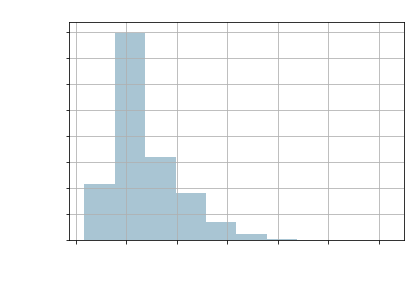

In [29]:

fig, ax = plt.subplots()
all_data['birth_date'].hist(color='#A9C5D3')
ax.set_title('Birth date Histogram', fontsize=12, color='w')
ax.set_xlabel('birth_date', fontsize=12, color='w')
ax.set_ylabel('Frequency', fontsize=12, color='w')
plt.xticks(color='w')
plt.yticks(color='w')

(array([     0.,  25000.,  50000.,  75000., 100000., 125000., 150000.,
        175000., 200000., 225000.]), <a list of 10 Text yticklabel objects>)

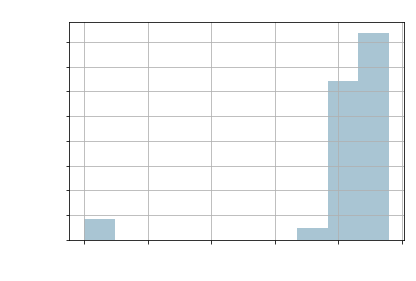

In [30]:
fig, ax = plt.subplots()
all_data['market_price'].hist(color='#A9C5D3')
ax.set_title('market_price Histogram', fontsize=12, color='w')
ax.set_xlabel('market_price', fontsize=12, color='w')
ax.set_ylabel('Frequency', fontsize=12, color='w')
plt.xticks(color='w')
plt.yticks(color='w')

(array([     0.,  50000., 100000., 150000., 200000., 250000.]),
 <a list of 6 Text yticklabel objects>)

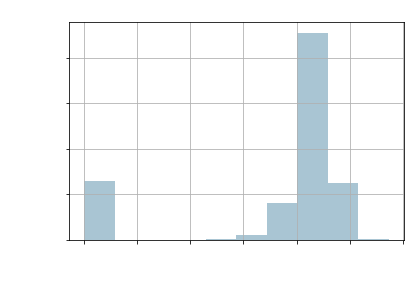

In [31]:
fig, ax = plt.subplots()
all_data['cust_point'].hist(color='#A9C5D3')
ax.set_title('cust_point Histogram', fontsize=12, color='w')
ax.set_xlabel('cust_point', fontsize=12, color='w')
ax.set_ylabel('Frequency', fontsize=12, color='w')
plt.xticks(color='w')
plt.yticks(color='w')

(array([     0.,  20000.,  40000.,  60000.,  80000., 100000., 120000.,
        140000., 160000., 180000.]), <a list of 10 Text yticklabel objects>)

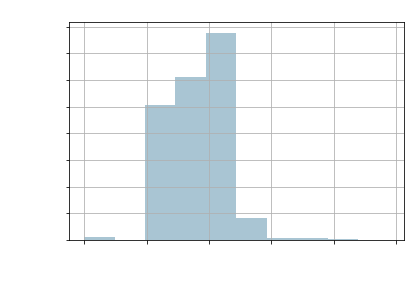

In [19]:
fig, ax = plt.subplots()
all_data['inet_pd_inst_cnt'].hist(color='#A9C5D3')
ax.set_title('inet_pd_inst_cnt Histogram', fontsize=12, color='w')
ax.set_xlabel('inet_pd_inst_cnt', fontsize=12, color='w')
ax.set_ylabel('Frequency', fontsize=12, color='w')
plt.xticks(color='w')
plt.yticks(color='w')

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125]),
 <a list of 126 Text yticklabel objects>)

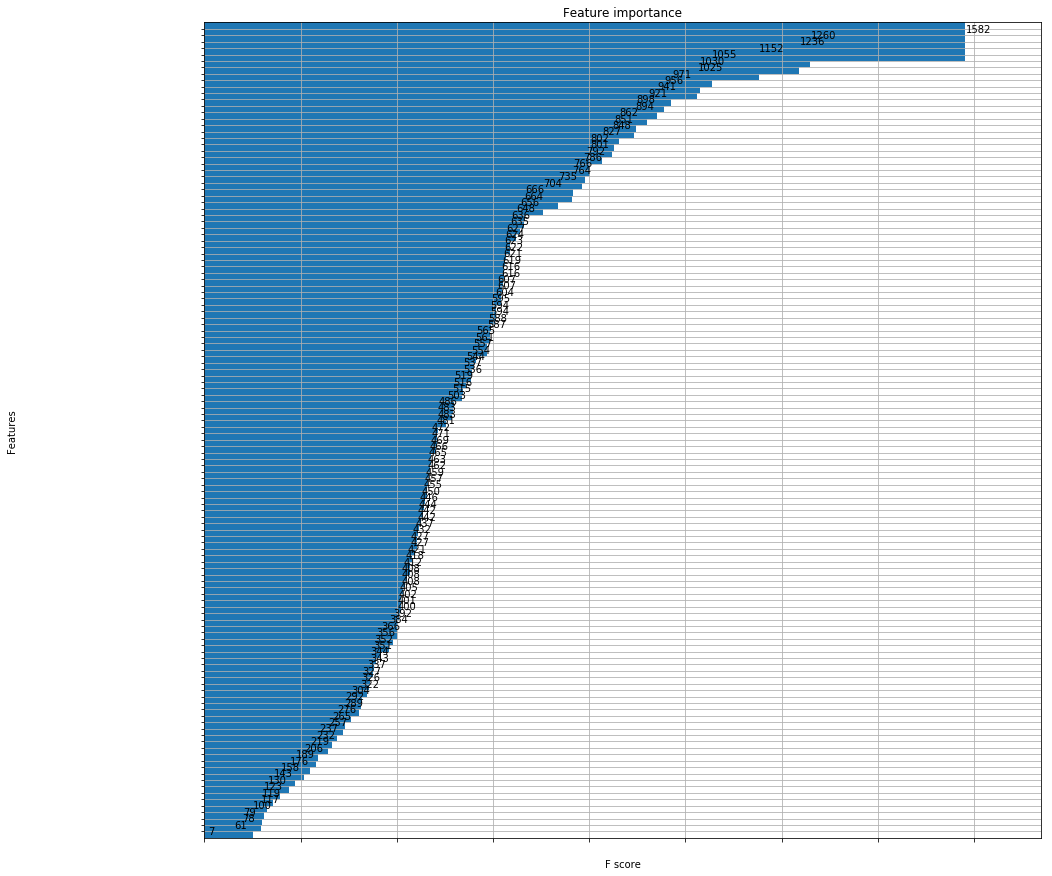

In [18]:
# 可视化1级分类器的特征重要性
from xgboost import plot_importance
fig,ax = plt.subplots(figsize=(15,15))
plot_importance(xgb_model_1, height=10,
                ax=ax)
plt.xticks(color='w')
plt.yticks(color='w')

# plot_importance(xgb_model_2, max_num_features=20)

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124]),
 <a list of 125 Text yticklabel objects>)

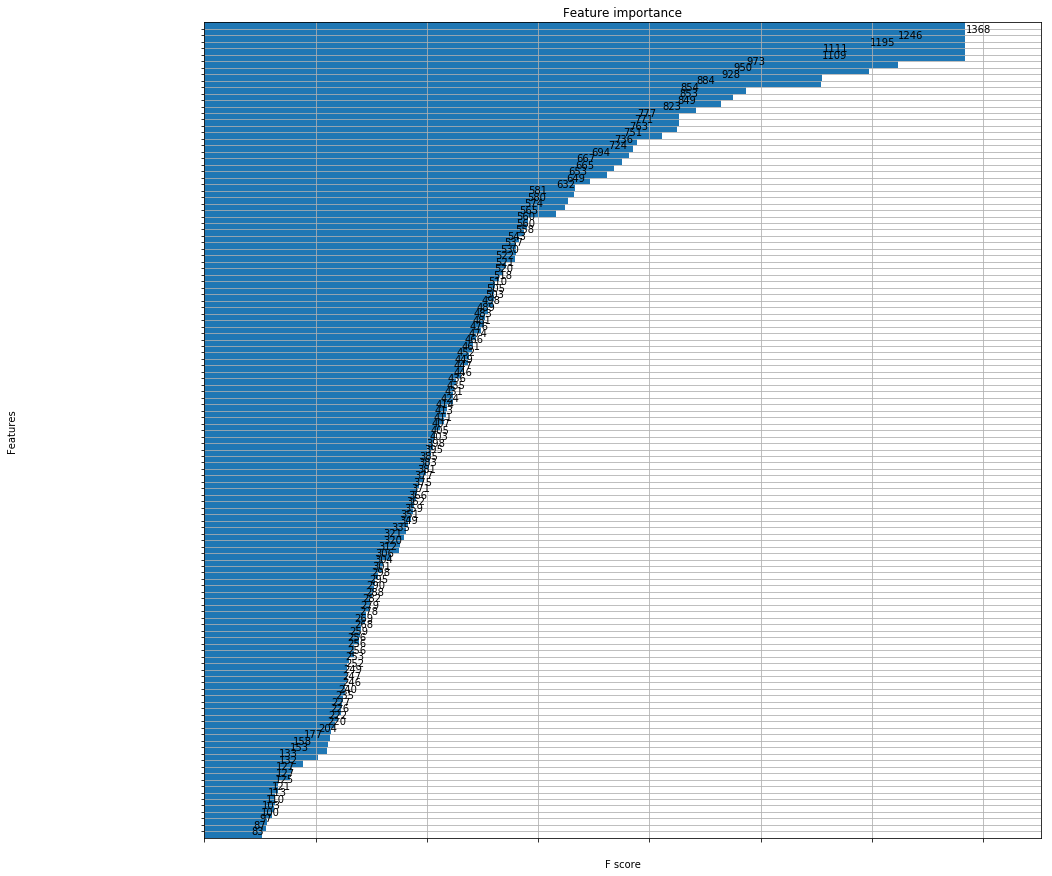

In [19]:
# 可视化2级分类器的特征重要性
from xgboost import plot_importance
fig,ax = plt.subplots(figsize=(15,15))
plot_importance(xgb_model_2, height=10,
                ax=ax)

# plot_importance(xgb_model_2, max_num_features=20)
plt.xticks(color='w')
plt.yticks(color='w')

In [ ]:
#把两个分类模型合起来
# ？？TODO
X_train['label'] = y_train
X_train_3 = X_train[X_train.label != 2.0]
y_train_3 = X_train_3['label']
X_train = X_train.drop(['label'], axis=1)
X_train_3 = X_train_3.drop(['label'], axis=1)

X_test['label'] = y_test
X_test_3 = X_test[X_test.label != 2.0]
y_test_3 = X_test_3['label']
X_test = X_test.drop(['label'], axis=1)
X_test_3 = X_test_3.drop(['label'], axis=1)

model = xgb.XGBClassifier(learning_rate=0.05, n_estimators=400, max_depth=6, min_child_weight=1,
                subsample=0.9, colsample_bytree=0.9, gamma=0.2, reg_alpha=0.05, reg_lambda=0.1, n_jobs=-1)

starttime = datetime.datetime.now()
xgb_model_3 = model.fit(X_train_3, y_train_3)
endtime = datetime.datetime.now()
print("耗时：%d" %(endtime - starttime).seconds +"s")

# 对训练集进行预测
y_pred_3 = xgb_model_3.predict(X_train_3)
print_metrics(y_train_3, y_pred_3)

y_pred_3 = xgb_model_3.predict(X_test_3)
print_metrics(y_test_3, y_pred_3)

#组合2个分类器进行预测
def predict_func(model_1, model_2, X):
    y_pred_1 = model_1.predict(X)
    
    # 拿到一级分类器分类为其他类别(0,1,3,4)的样本
    idx = np.where(y_pred_1 == 1)[0]
    X_2 = X.iloc[idx, :]
    y_pred_2 = model_2.predict(X_2)
    
    y_pred_1 = pd.Series(y_pred_1)
    y_pred = y_pred_1.apply(lambda x:2.0 if x==0 else x)
    y_pred.iloc[idx] = y_pred_2
    return y_pred


In [55]:
# 准备第二级分类的数据
from imblearn.over_sampling import SMOTE

# idx = np.where(y_pred_1 == 1)[0]
X_train = X_train
y_train = y_train

sm = SMOTE(random_state=22)
X_train, y_train = sm.fit_resample(X_train, y_train)



In [17]:
# 把2类和0类标签互换，所有的小类就成了正类，方便使用scale_pos_weigt
import datetime
def label_transform(y): # 
    if y == 2: return 0
    elif y == 0: return 2
    else: return y
    
y_train_2 = y_train_2.apply(label_transform)
y_test = y_test.apply(label_transform)

model = xgb.XGBClassifier(learning_rate=0.07, n_estimators=500, max_depth=6, min_child_weight=4, subsample=0.9, 
                          colsample_bytree=0.9, gamma=0.2, reg_alpha=0.05, reg_lambda=0.1, silent=0, 
                          objective='multi:softmax', scale_pos_weight=20, n_jobs=-1)
starttime = datetime.datetime.now()
weighted_xgb_model = model.fit(X_train_2, y_train_2)
endtime = datetime.datetime.now()
print("耗时：%d" %(endtime - starttime).seconds +"s")

y_pred = weighted_xgb_model.predict(X_test)
y_pred = pd.Series(y_pred)
y_pred = y_pred.apply(label_transform)
print_metrics(y_test, y_pred)

耗时：390s
f1 0.5279476650225446
p 0.5274902207856018
r 0.5595103772798005
confusion matrix [[   77   123 84252   259   106]
 [   13  2402   110   100    31]
 [ 2469     9   468   304     1]
 [  169    82   337  4806     5]
 [    1     4    91     4   605]]
confusion matrix [[2.82154635e-02 4.69465649e-02 9.88200521e-01 4.73232231e-02
  1.41711230e-01]
 [4.76364969e-03 9.16793893e-01 1.29020151e-03 1.82715147e-02
  4.14438503e-02]
 [9.04727006e-01 3.43511450e-03 5.48922095e-03 5.55454047e-02
  1.33689840e-03]
 [6.19274460e-02 3.12977099e-02 3.95270825e-03 8.78128997e-01
  6.68449198e-03]
 [3.66434591e-04 1.52671756e-03 1.06734852e-03 7.30860588e-04
  8.08823529e-01]]


# LGB

In [100]:
# 准备第二级分类的数据
from imblearn.over_sampling import SMOTE

# idx = np.where(y_pred_1 == 1)[0]
# X_train_2 = X_train.iloc[idx, :]
# y_train_2 = y_train.iloc[idx]

sm = SMOTE(random_state=22)
X_train, y_train = sm.fit_resample(X_train, y_train)

In [101]:
# X_train_2 = pd.Series(X_train_2)
y_train_2 = pd.Series(y_train_2)

In [80]:
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score,roc_auc_score,accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn import preprocessing
from itertools import cycle
from sklearn import svm
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import log_loss
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import StackingClassifier
#基于Scikit-learn接口的xgboost多分类
import datetime
from sklearn.ensemble import RandomForestClassifier
## 第一级的二分类
# 转换标签
y_train_1 = y_train.apply(lambda x:1 if x!=2.0 else 0) # 1-其他类别(0,1,3,4)，0-数目最大的类别(2)
X_train_1 = X_train
# model = lgb.LGBMClassifier( 
#     boosting_type= 'gbdt',  objective='binary',  n_estimators=291,  
#     learning_rate=0.1, lambda_l2= 0.6,    max_depth= 6, min_child_weight= 4
# )
model = xgb.XGBClassifier(learning_rate=0.07, n_estimators=500, max_depth=9, min_child_weight=1,
                subsample=0.9, colsample_bytree=0.9, gamma=0.2, reg_alpha=0.05, reg_lambda=0.1, n_jobs=-1,
                          objective='binary:logistic',scale_pos_weight=200)
# from sklearn.svm import SVC
# svc = SVC(decision_function_shape='ovr')
# model = RandomForestClassifier(n_jobs=2)

starttime = datetime.datetime.now()
xgb_model_1 = model.fit(X_train_1, y_train_1)
endtime = datetime.datetime.now()
print("耗时：%d" %(endtime - starttime).seconds +"s")

# 对训练集进行预测
y_pred_1 = xgb_model_1.predict(X_train_1)
print_metrics(y_train_1, y_pred_1)

# 对测试集进行预测
y_pred_1_test = xgb_model_1.predict(X_test)
# 转换标签
y_true_1 = y_test.apply(lambda x:1 if x!=2.0 else 0)
print_metrics(y_true_1, y_pred_1_test)

耗时：649s
f1 0.9958069524326174
p 0.9927084808155175
r 0.9989600634058429
confusion matrix [[197677    412]
 [     0  27840]]
confusion matrix [[1.         0.01458304]
 [0.         0.98541696]]
f1 0.9588362048139816
p 0.9563176841428799
r 0.9613941964394388
confusion matrix [[83868   949]
 [  793 11218]]
confusion matrix [[0.99063323 0.07799786]
 [0.00936677 0.92200214]]


In [81]:
from sklearn import neighbors
from sklearn.svm import SVC

## 第二级的多分类
idx = np.where(y_pred_1 == 1)[0]
X_train_2 = X_train.iloc[idx, :]
y_train_2 = y_train.iloc[idx]
# model = xgb.XGBClassifier(learning_rate=0.07, n_estimators=500, max_depth=6, min_child_weight=1, objective='multi:softmax',
#                 subsample=0.9, colsample_bytree=0.9, gamma=0.5, reg_alpha=0.05, reg_lambda=0.1, n_jobs=-1,
#                          num_class=5,eval_metric='mlogloss')
model = lgb.LGBMClassifier( 
    boosting_type= 'gbdt',  objective='multiclass',  num_class= 5,metric= 'multi_error',  
    n_estimators=291,
    learning_rate=0.1,    max_depth= 6, min_child_weight= 4,lambda_l2= 3
)
# param_test1 = {'n_estimators': range(10, 100, 10)}
# model = GridSearchCV(
#     estimator=RandomForestClassifier(random_state=10),param_grid=param_test1, scoring='f1', cv=5)
# model = neighbors.KNeighborsClassifier()  
# model = SVC(kernel='rbf',decision_function_shape='ovr',class_weight='balanced')
starttime = datetime.datetime.now()
xgb_model_2 = model.fit(X_train_2, y_train_2)
endtime = datetime.datetime.now()
print("耗时：%d" %(endtime - starttime).seconds +"s")

# 对训练集进行预测
y_pred_2 = xgb_model_2.predict(X_train_2)
print_metrics(y_train_2, y_pred_2)

# 对测试集进行预测
# 拿到一级分类器分类为其他类别(0,1,3,4)的样本
idx = np.where(y_pred_1_test == 1)[0]
X_2 = X_test.iloc[idx, :]
y_pred_2 = xgb_model_2.predict(X_2)
y_true_2 = y_test.iloc[idx]
print('二级分类器：')
print_metrics(y_true_2, y_pred_2)

耗时：33s
f1 0.984460805841709
p 0.9847439999642875
r 0.9844195601385645
confusion matrix [[11886    10    39   478     0]
 [   15 12259    29   110     0]
 [    1     3 12323    86     0]
 [  125    46    20 12218     4]
 [    0     0     0     1 12412]]
confusion matrix [[9.88276378e-01 8.11820101e-04 3.14237370e-03 3.70743814e-02
  0.00000000e+00]
 [1.24719381e-03 9.95210261e-01 2.33663685e-03 8.53176142e-03
  0.00000000e+00]
 [8.31462543e-05 2.43546030e-04 9.92909516e-01 6.67028620e-03
  0.00000000e+00]
 [1.03932818e-02 3.73437246e-03 1.61147369e-03 9.47646009e-01
  3.22164948e-04]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 7.75614675e-05
  9.99677835e-01]]


ValueError: Number of features of the model must match the input. Model n_features_ is 130 and input n_features is 126 

In [15]:

def predict_func(model_1, model_2, X):
    y_pred_1 = model_1.predict(X)
    
    # 拿到一级分类器分类为其他类别(0,1,3,4)的样本
    idx = np.where(y_pred_1 == 1)[0]
    X_2 = X.iloc[idx, :]
    y_pred_2 = model_2.predict(X_2)
    
    y_pred_1 = pd.Series(y_pred_1)
    y_pred = y_pred_1.apply(lambda x:2.0 if x==0 else x)
    y_pred.iloc[idx] = y_pred_2
    return y_pred


In [96]:
test_data=test_data.drop(['pred_label'],axis=1)
X_pred = test_data.drop(['label','user', 'product_nbr',  'pro_brand', 'term_model'
#                          , 'last_year_capture_user_flag', 'membership_level'
                        ],axis=1)
# result = predict_func(xgb_model_1,xgb_model_2,X_pred)
y_pred = classifier.predict(X_pred)
result.value_counts()
y_pred = result.astype('int64')
from collections import Counter
print(Counter(y_pred))
#预测结果反编码
y_pred = le_label.inverse_transform(y_pred)
print(Counter(y_pred))
test_data['pred_label'] = y_pred

'''
le_tabel.classes_
array(['0F2E4CC10EDBE80F', '56AFA2A526F96CC9', '7C26FADD409BD4B9',
       '816A9BEBED2D7C99', 'C7E2941B65C6CCD6'], dtype=object)'''
test_data[['user','pred_label']].to_csv('pred1.csv',encoding = 'utf-8',index = None, header = None)

Counter({2: 70443, 3: 4464, 1: 2472, 0: 1287, 4: 741})
Counter({'7C26FADD409BD4B9': 70443, '816A9BEBED2D7C99': 4464, '56AFA2A526F96CC9': 2472, '0F2E4CC10EDBE80F': 1287, 'C7E2941B65C6CCD6': 741})


# 试试adaboost

In [101]:
from sklearn.ensemble import AdaBoostClassifier
classifier = AdaBoostClassifier(
    lgb.LGBMClassifier(
    boosting_type= 'gbdt',  objective='multiclass',  num_class= 5,metric= 'multi_error',  
      max_depth= 6, min_child_weight= 4,lambda_l2= 1),
     learning_rate=1.0, n_estimators=300
)
classifier.fit(X_train, y_train)

MemoryError: 


## 试试SVM

In [111]:
from sklearn.svm import SVC

svc = SVC(decision_function_shape='ovr')

starttime = datetime.datetime.now()
svc_model = svc.fit(X_train_3, y_train_3)
endtime = datetime.datetime.now()
print("耗时：%d" %(endtime - starttime).seconds +"s")

# 对训练集进行预测
y_pred_3 = svc_model.predict(X_train_3)
print_metrics(y_train_3, y_pred_3)

y_pred_3 = svc_model.predict(X_test_3)
print_metrics(y_test_3, y_pred_3)

/home/zhangsen/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


耗时：69s
f1 0.8146963058701873
p 0.8214869237472466
r 0.8156609195402299
confusion matrix [[ 6015    49  1324   153]
 [  104  4458  1634   102]
 [  781   546 10981   105]
 [  134    22   178  1254]]
confusion matrix [[0.85513221 0.00965517 0.09378763 0.09479554]
 [0.01478533 0.87842365 0.11574697 0.06319703]
 [0.11103213 0.10758621 0.77785649 0.06505576]
 [0.01905033 0.00433498 0.01260891 0.77695167]]
f1 0.8091824935435625
p 0.8143778528610125
r 0.8101740071601032
confusion matrix [[2592   25  554   80]
 [  50 1879  675   52]
 [ 392  244 4721   42]
 [  75   12   79  539]]
confusion matrix [[0.83370859 0.01157407 0.0918892  0.11220196]
 [0.01608234 0.86990741 0.11195887 0.07293128]
 [0.12608556 0.11296296 0.7830486  0.05890603]
 [0.02412351 0.00555556 0.01310333 0.75596073]]


In [17]:
xgb_model_1.feature_importances_, 

array([0.01189053, 0.0055813 , 0.0527881 , 0.00361902, 0.00336546,
       0.00457817, 0.0074858 , 0.00315879, 0.00374924, 0.02369842,
       0.00631737, 0.0033229 , 0.00728278, 0.01259493, 0.00431154,
       0.0051496 , 0.00334112, 0.00488181, 0.0062555 , 0.38268313,
       0.0077489 , 0.15175827, 0.00774574, 0.00377237, 0.00848558,
       0.01532182, 0.00381899, 0.00343939, 0.01357726, 0.01017074,
       0.00471716, 0.00386712, 0.00340748, 0.00393226, 0.00306907,
       0.00483085, 0.00406072, 0.01950792, 0.00449359, 0.00401759,
       0.00447877, 0.00480376, 0.00699856, 0.00581976, 0.00280148,
       0.0038856 , 0.0044296 , 0.00722889, 0.00356425, 0.00478013,
       0.04136092, 0.00426254, 0.00468409, 0.00388536, 0.00392864,
       0.003497  , 0.00345003, 0.00349847, 0.00316584, 0.00278631,
       0.00267982, 0.00302205, 0.0035565 , 0.00298177, 0.00349476,
       0.00375021, 0.00342807, 0.00367783, 0.00857211, 0.00372855],
      dtype=float32)

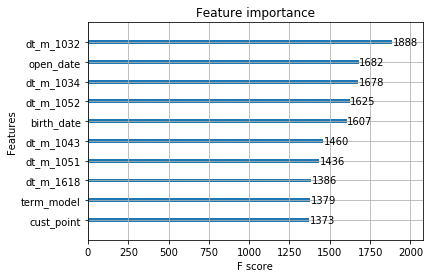

In [24]:
from xgboost import plot_importance

plot_importance(xgb_model_1, max_num_features=10)

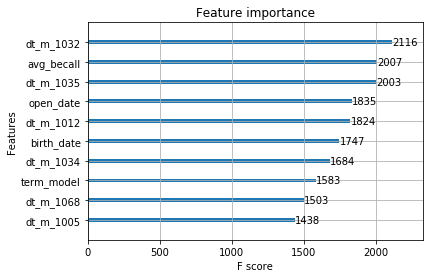

In [25]:
plot_importance(xgb_model_2, max_num_features=10)

In [72]:
import time
def months(str1,str2):
    from datetime import datetime,timedelta
    if len(str2)==6:
        str1_d = datetime.strptime(str1, "%Y%m")
        str2_d = datetime.strptime(str2, "%Y%m")
        num=(str1_d.year-str2_d.year)*12+(str1_d.month-str2_d.month)
    elif len(str2)==7:
        str1_d = datetime.strptime(str1, "%Y%m")
        str2_d = datetime.strptime(str2, "%Y-%m")
        num = (str1_d.year-str2_d.year)*12+(str1_d.month-str2_d.month)
    else:
        num=-1
    return num

def print_metrics(y_true, y_pred):
    f1 = f1_score(y_true, y_pred, average='weighted')
    p = precision_score(y_true, y_pred, average='weighted')
    r = recall_score(y_true, y_pred, average='weighted')
    print('f1',f1)
    print('p',p)
    print('r',r)

    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y_true, y_pred)
    print('confusion matrix', cm)
    cm = cm / cm.sum(axis=0, keepdims=True)
    print('confusion matrix', cm)

In [75]:
# 数据准备
train_data = all_data[all_data['label']!=-1]
test_data = all_data[all_data['label']==-1]

# 过滤只要少类样本
train_data = train_data[train_data['label']!=2.0]

from sklearn.model_selection import train_test_split

X=train_data.drop(['label','user','product_nbr', 'pro_brand', 'term_model'],axis=1)
X = X.drop([
 'last_year_capture_user_flag',
 'membership_level'],axis=1)
y=train_data['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=22)

In [76]:
# 模型训练
import datetime
model = xgb.XGBClassifier(learning_rate=0.07, n_estimators=500, max_depth=6, min_child_weight=4, subsample=0.9, 
                          colsample_bytree=0.9, gamma=0.2, reg_alpha=0.05, reg_lambda=0.1, silent=True, 
                          objective='multi:softmax', n_jobs=-1)
starttime = datetime.datetime.now()
xgb_model = model.fit(X_train, y_train)
endtime = datetime.datetime.now()
print("耗时：%d" %(endtime - starttime).seconds +"s")

耗时：102s


In [77]:
# 训练集效果
y_pred = xgb_model.predict(X_train)
print_metrics(y_train, y_pred)

# 测试集效果
y_pred = xgb_model.predict(X_test)
print_metrics(y_test, y_pred)

f1 0.9917131408824094
p 0.9917897963071713
r 0.9917189460476789
confusion matrix [[ 7405     1   161     0]
 [    2  6232    34     0]
 [   25     8 12412     0]
 [    0     0     0  1615]]
confusion matrix [[9.96367061e-01 1.60230732e-04 1.27706830e-02 0.00000000e+00]
 [2.69106566e-04 9.98557923e-01 2.69691441e-03 0.00000000e+00]
 [3.36383208e-03 1.28184586e-03 9.84532403e-01 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00]]
f1 0.9144302700985792
p 0.9151579830482063
r 0.9144362663098026
confusion matrix [[2815    9  393    8]
 [  30 2463  152   41]
 [ 270   67 5011   19]
 [  10   13   11  644]]
confusion matrix [[0.9008     0.00352665 0.07059458 0.01123596]
 [0.0096     0.96512539 0.02730375 0.05758427]
 [0.0864     0.02625392 0.90012574 0.02668539]
 [0.0032     0.00509404 0.00197593 0.90449438]]


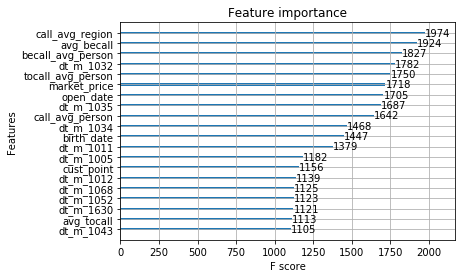

In [34]:
xgb.plot_importance(xgb_model, max_num_features=20)